# Apache request analysis
---
Quentin Fournier & Naser Ezzati

# 1. Load data

In [1]:
from functions import load_data


In [2]:
counts, times, syscalls, states, duration = load_data()


# 2. Data preprocessing

Contrary to multidimensinal data, there is no simple and automatic way of clustering sequences. One may:

* carefully design a distance metric to still be able to use DBSCAN
* learn a fixed length representation of the sequence with a specificly taylored RNN (such as LSTM) for the dataset
* use a specific methods for clustering such sequences (different length and events not equally spaced in time)

Because we are interested in automatic methods that could be applied to any type of request, we will transform the sequence with a simple bag of word method. This provide a count of each word (here system calls or states) in the sequence. However, we loose temporal information.

In [3]:
# convert feature times and duration into ms
duration = [d / 1e6 for d in duration]
times = [[t / 1e6 for t in sample] for sample in times]


Note that if we use feature duration (parameter `times`), then `sum(data[i]) == time[i]`

# 3. Data statistics

In [4]:
from functions import extrema
from functions import corr_coeff
from functions import time_statistics
from functions import syscalls_statistics


In [5]:
time_statistics(duration)
syscalls_statistics(syscalls)

	Size                :      45413

Duration:
	Min                 :       0.14 ms
	Max                 :   22381.73 ms
	Median              :     122.41 ms
	Mean                :     139.15 ms
	Std                 :     511.31 ms

Probabilities
	P(duration > 200ms) :     5.309%
	P(duration > 250ms) :     0.949%
	P(duration > 300ms) :     0.339%

System Call Sequence Length:
	Min                 :       9.00
	Max                 :    2855.00
	Median              :     247.00
	Mean                :     247.12
	Std                 :      36.92

Number of Distinct System Calls:
	Min                 :       8.00
	Max                 :      30.00
	Median              :      26.00
	Mean                :      26.01
	Std                 :       0.18



In [6]:
extrema(duration)


0.14, 4.22, 20.5, 20.81, 21.56 ... 21853.77, 21918.74, 21930.77, 22111.73, 22381.73


In [7]:
# 0.14 and 4.22 are most likely to be measurment errors
for _ in range(2):
    index = duration.index(min(duration))
    del counts[index]
    del times[index]
    del syscalls[index]
    del states[index]
    del duration[index]


In [8]:
extrema(duration)


20.5, 20.81, 21.56, 21.89, 22.01 ... 21853.77, 21918.74, 21930.77, 22111.73, 22381.73


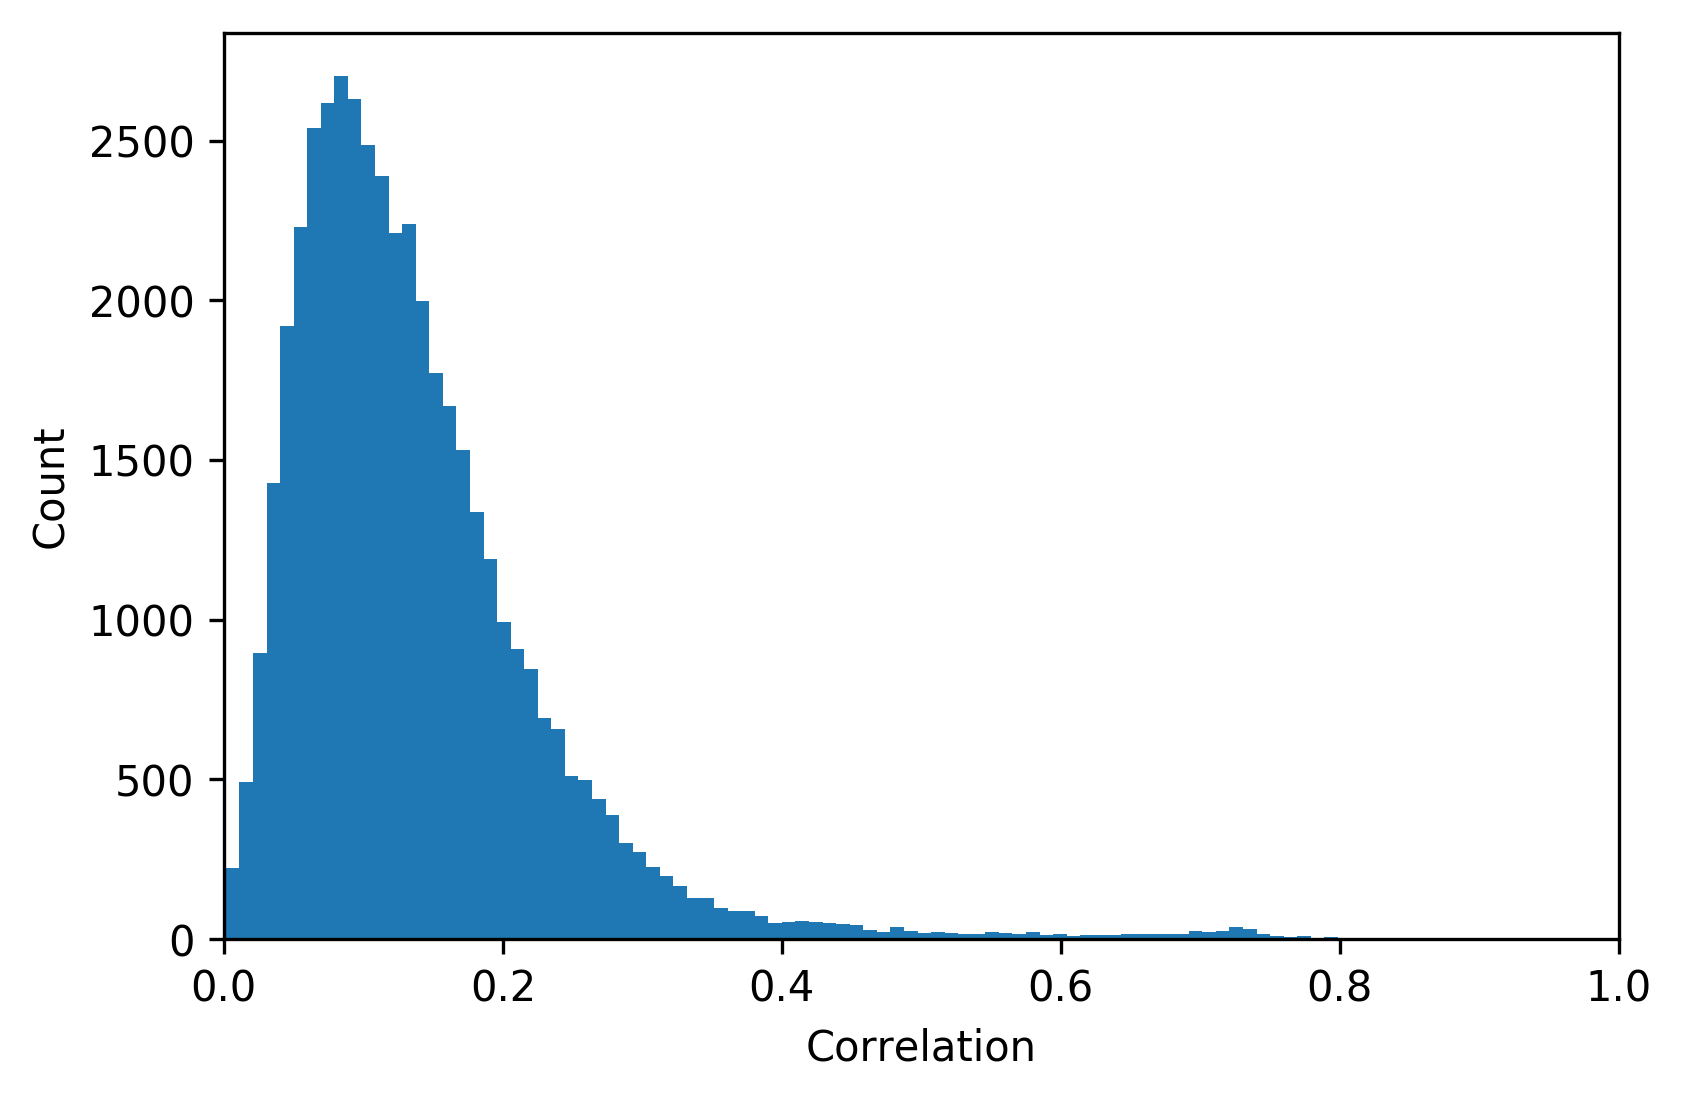

In [9]:
cov = corr_coeff(counts, times)


The correlation (**linear relashionship**) between the feature counts and feature times is small.

# 4. Clustering

In [10]:
from functions import pipeline
from sklearn.cluster import DBSCAN
from MulticoreTSNE import MulticoreTSNE
from sklearn.ensemble import IsolationForest


## 4.1 Based on system call count (BoW)

--------------------------------------------------
Cluster 0
--------------------------------------------------
	Size                :      45183

Duration:
	Min                 :      20.50 ms
	Max                 :   22381.73 ms
	Median              :     122.29 ms
	Mean                :     128.31 ms
	Std                 :     182.68 ms

Probabilities
	P(duration > 200ms) :     5.159%
	P(duration > 250ms) :     0.837%
	P(duration > 300ms) :     0.241%

--------------------------------------------------
Cluster 1
--------------------------------------------------
	Size                :        228

Duration:
	Min                 :      25.87 ms
	Max                 :   21930.77 ms
	Median              :     155.88 ms
	Mean                :    2288.27 ms
	Std                 :    6388.87 ms

Probabilities
	P(duration > 200ms) :    35.088%
	P(duration > 250ms) :    23.246%
	P(duration > 300ms) :    19.737%



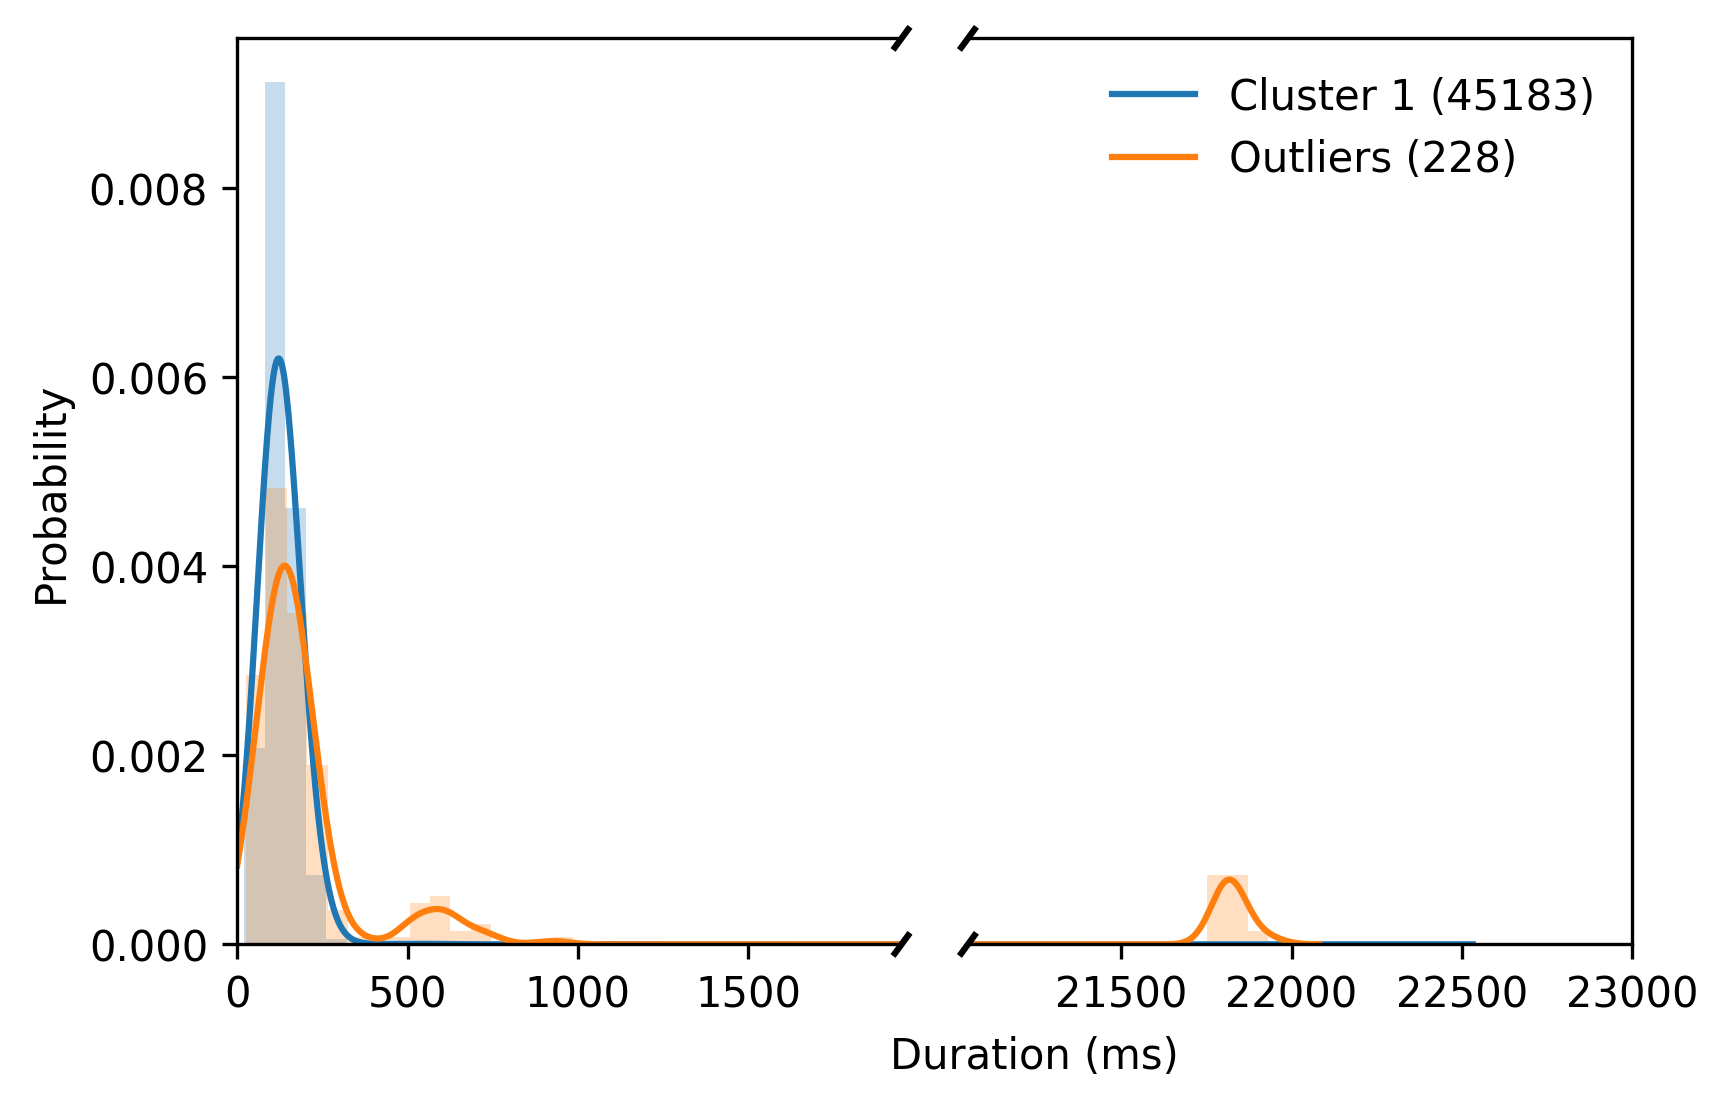

array([-1,  1,  1, ...,  1,  1,  1])

In [11]:
model = IsolationForest(
    n_estimators=250,
    contamination=0.005,
    behaviour='new',
    max_features=1.0,
    n_jobs=-1)
pipeline(syscalls, duration, model, bow=True)


--------------------------------------------------
Cluster 0
--------------------------------------------------
	Size                :      45211

Duration:
	Min                 :      20.50 ms
	Max                 :   22111.73 ms
	Median              :     122.34 ms
	Mean                :     127.78 ms
	Std                 :     152.69 ms

Probabilities
	P(duration > 200ms) :     5.174%
	P(duration > 250ms) :     0.829%
	P(duration > 300ms) :     0.226%

--------------------------------------------------
Cluster 1
--------------------------------------------------
	Size                :        200

Duration:
	Min                 :      25.87 ms
	Max                 :   22381.73 ms
	Median              :     147.61 ms
	Mean                :    2710.31 ms
	Std                 :    6888.64 ms

Probabilities
	P(duration > 200ms) :    36.000%
	P(duration > 250ms) :    28.000%
	P(duration > 300ms) :    26.000%



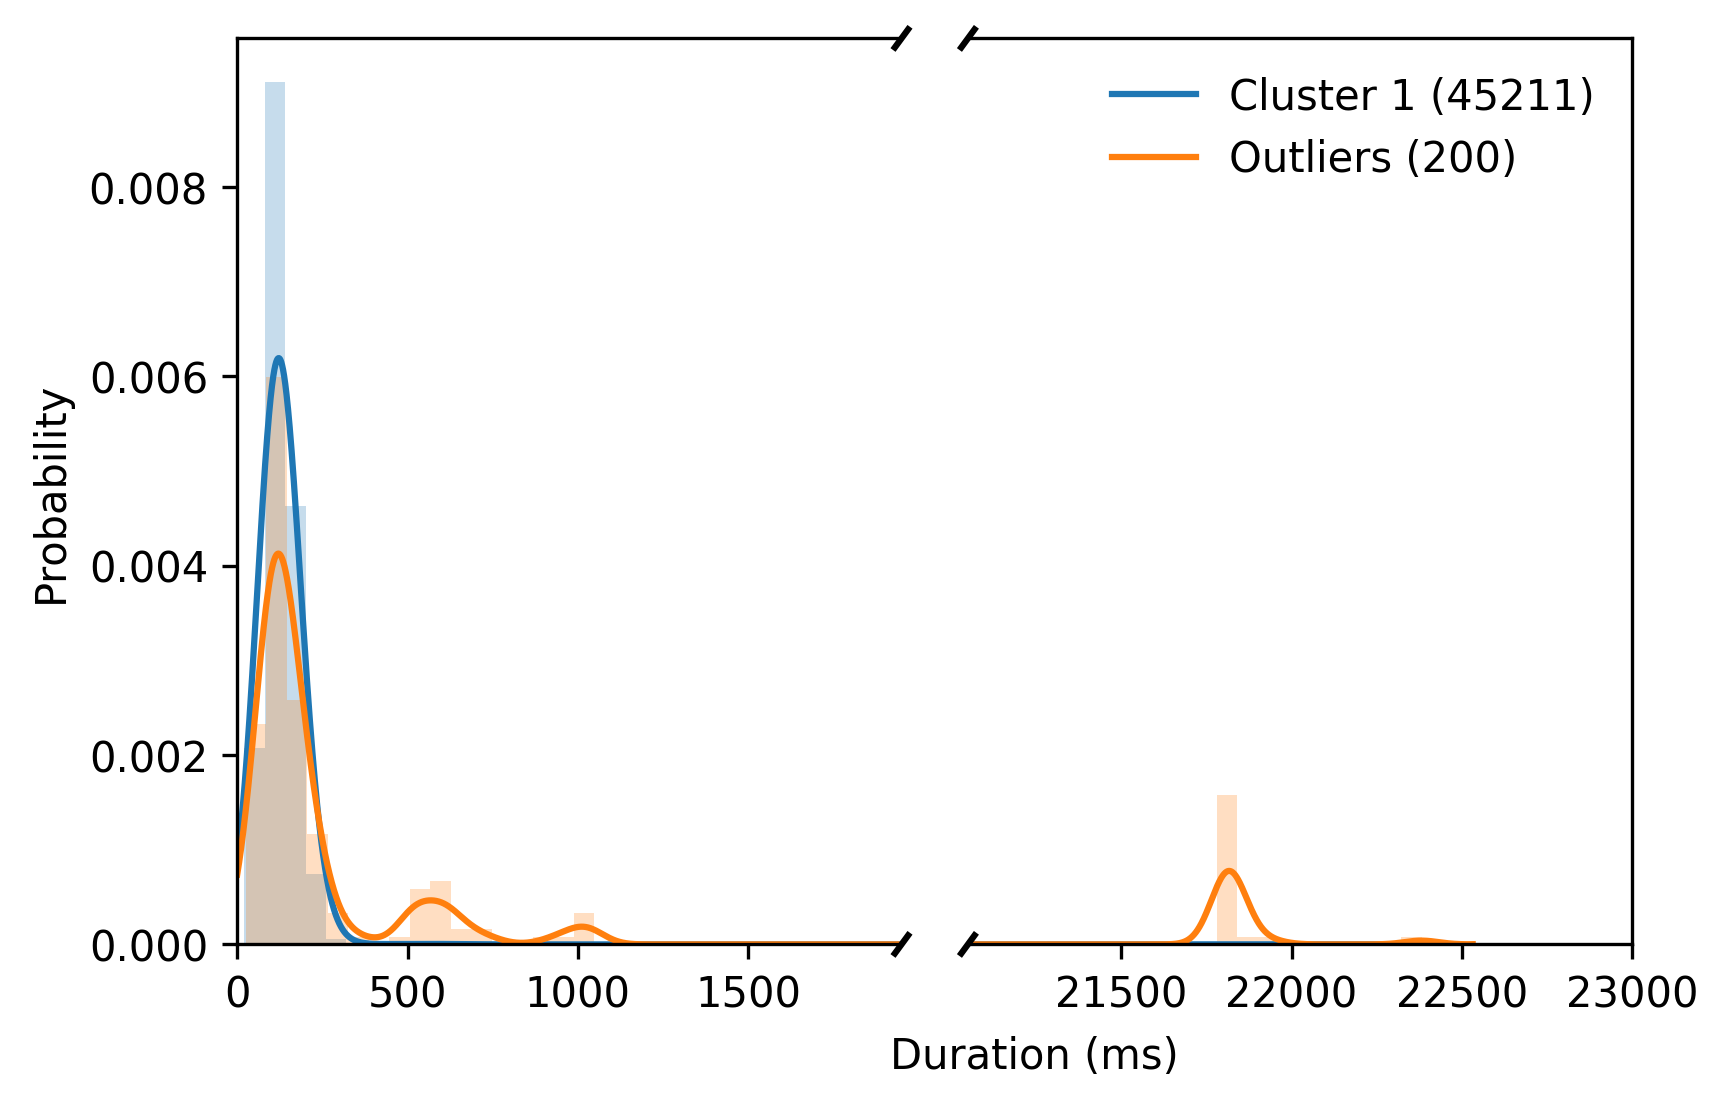

array([-1,  0,  0, ...,  0,  0,  0])

In [12]:
model = DBSCAN(eps=10, min_samples=100, n_jobs=-1, algorithm='ball_tree')
pipeline(syscalls, duration, model, bow=True, name="syscall_bow")


## 4.2 Based on system call count (TF-IDF)

--------------------------------------------------
Cluster 0
--------------------------------------------------
	Size                :      45049

Duration:
	Min                 :      20.50 ms
	Max                 :   22381.73 ms
	Median              :     122.48 ms
	Mean                :     137.92 ms
	Std                 :     492.24 ms

Probabilities
	P(duration > 200ms) :     5.221%
	P(duration > 250ms) :     0.870%
	P(duration > 300ms) :     0.266%

--------------------------------------------------
Cluster 1
--------------------------------------------------
	Size                :        362

Duration:
	Min                 :      25.87 ms
	Max                 :   21810.85 ms
	Median              :     114.86 ms
	Mean                :     292.63 ms
	Std                 :    1618.79 ms

Probabilities
	P(duration > 200ms) :    16.298%
	P(duration > 250ms) :    10.773%
	P(duration > 300ms) :     9.392%



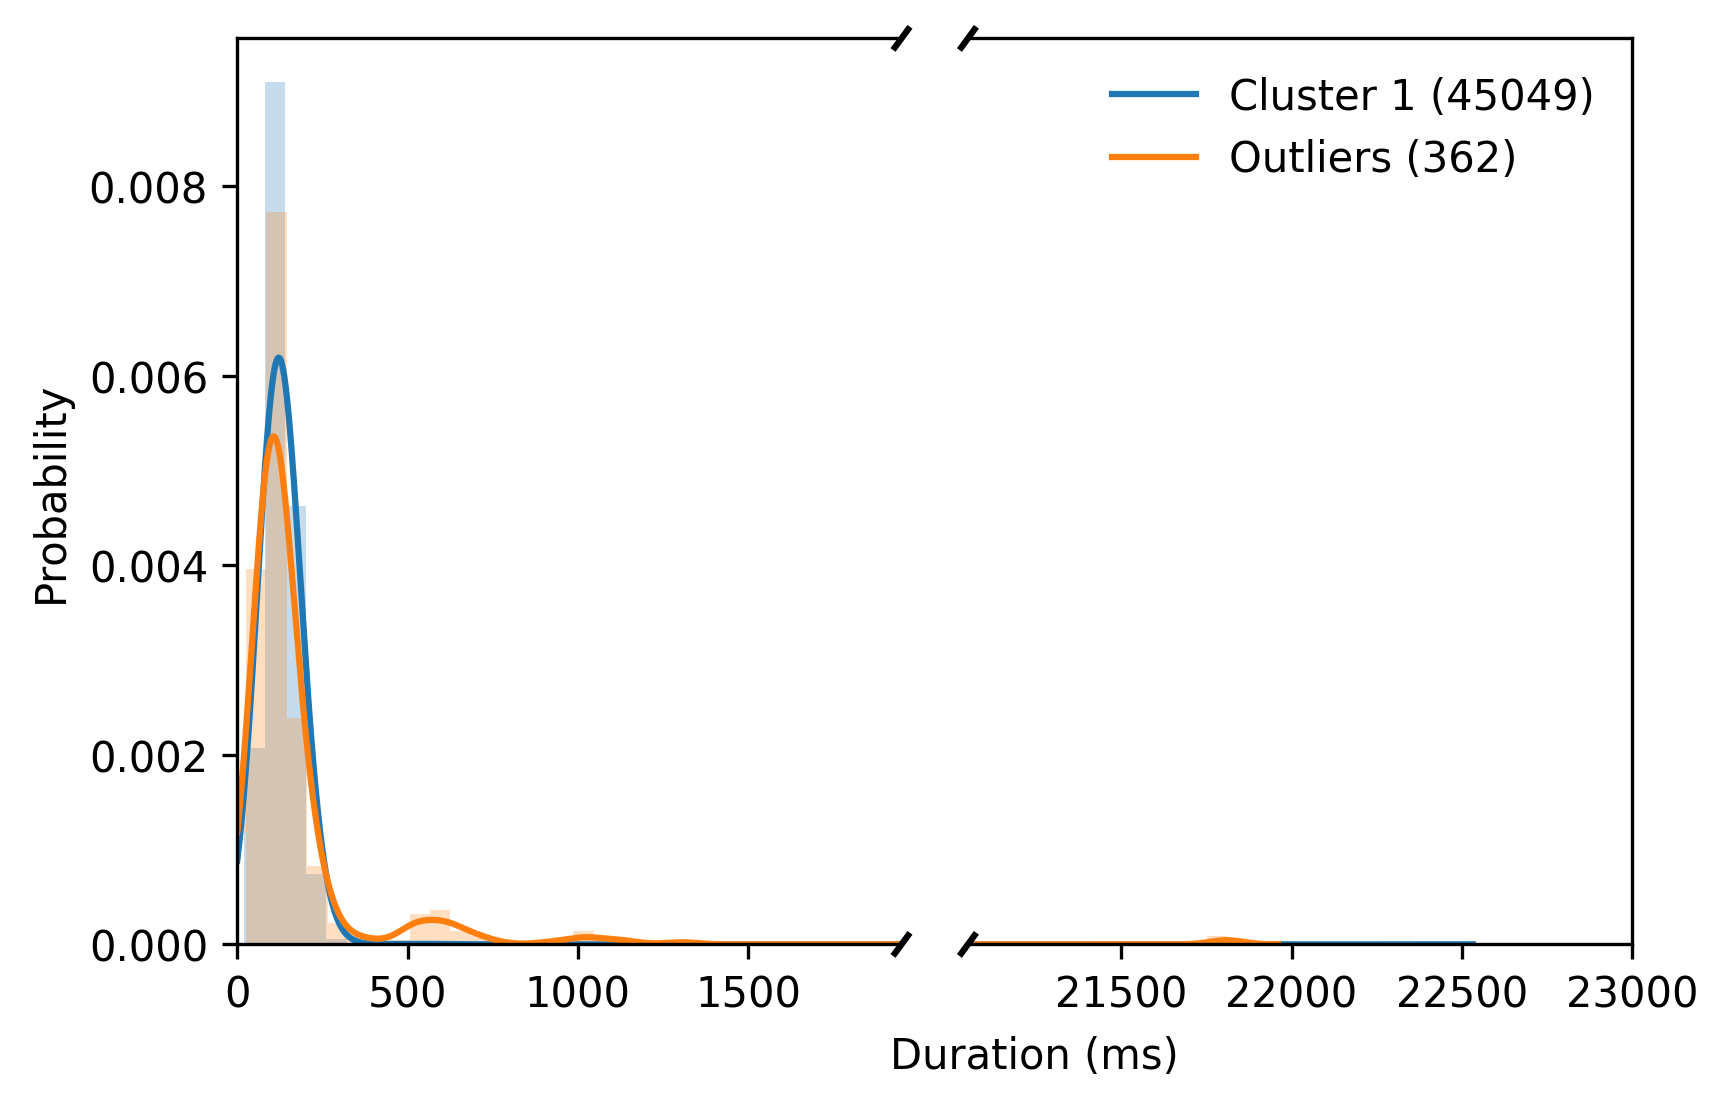

array([-1,  0,  0, ...,  0,  0,  0])

In [13]:
model = DBSCAN(eps=5e-4, min_samples=100, n_jobs=-1)
pipeline(syscalls, duration, model, tfidf=True, name="syscall_tfidf")


--------------------------------------------------
Cluster 0
--------------------------------------------------
	Size                :      45183

Duration:
	Min                 :      20.50 ms
	Max                 :   22381.73 ms
	Median              :     122.30 ms
	Mean                :     128.31 ms
	Std                 :     182.65 ms

Probabilities
	P(duration > 200ms) :     5.161%
	P(duration > 250ms) :     0.837%
	P(duration > 300ms) :     0.243%

--------------------------------------------------
Cluster 1
--------------------------------------------------
	Size                :        228

Duration:
	Min                 :      25.87 ms
	Max                 :   21930.77 ms
	Median              :     160.23 ms
	Mean                :    2287.96 ms
	Std                 :    6389.14 ms

Probabilities
	P(duration > 200ms) :    34.649%
	P(duration > 250ms) :    23.246%
	P(duration > 300ms) :    19.298%



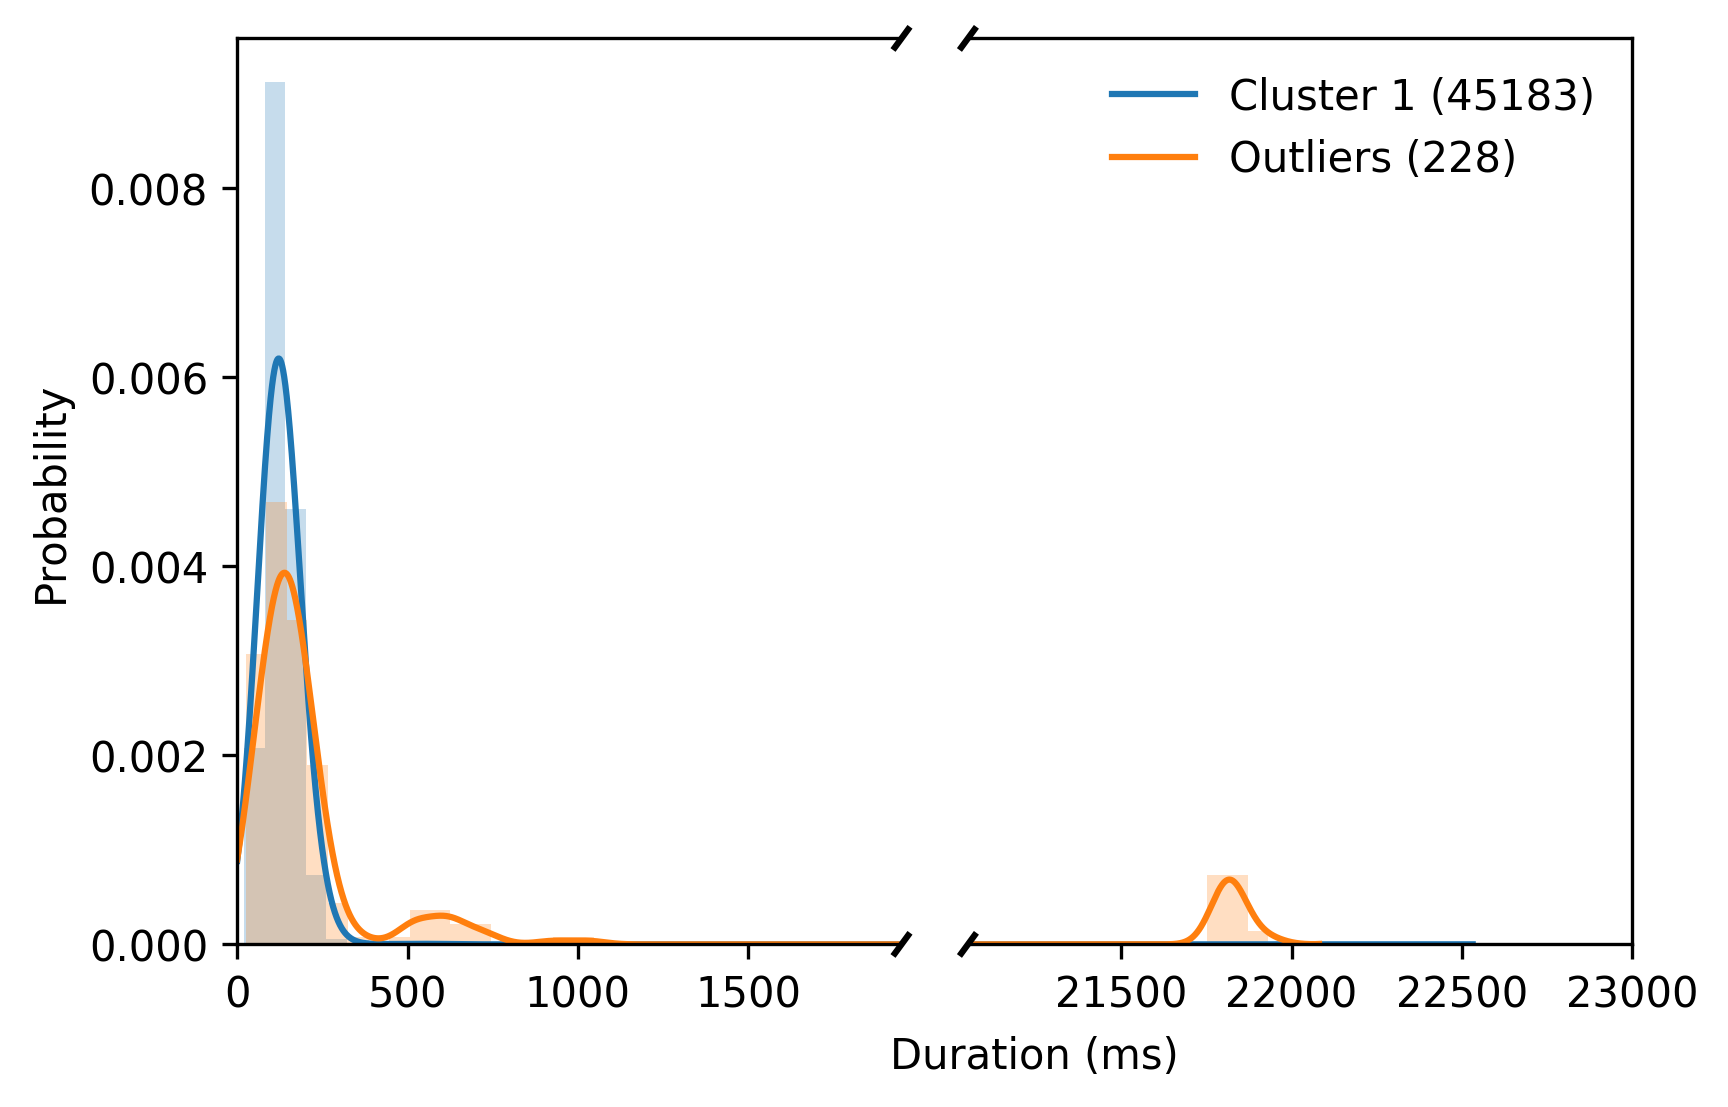

array([-1,  1,  1, ...,  1,  1,  1])

In [14]:
model = IsolationForest(
    n_estimators=250,
    contamination=0.005,
    behaviour='new',
    max_features=1.0,
    n_jobs=-1)
pipeline(syscalls, duration, model, tfidf=True)


## 4.3 Based on Features count (BoW)

--------------------------------------------------
Cluster 0
--------------------------------------------------
	Size                :      45183

Duration:
	Min                 :      20.50 ms
	Max                 :     728.33 ms
	Median              :     122.30 ms
	Mean                :     126.61 ms
	Std                 :      44.30 ms

Probabilities
	P(duration > 200ms) :     5.130%
	P(duration > 250ms) :     0.795%
	P(duration > 300ms) :     0.201%

--------------------------------------------------
Cluster 1
--------------------------------------------------
	Size                :        228

Duration:
	Min                 :      25.87 ms
	Max                 :   22381.73 ms
	Median              :     168.15 ms
	Mean                :    2623.97 ms
	Std                 :    6743.80 ms

Probabilities
	P(duration > 200ms) :    40.789%
	P(duration > 250ms) :    31.579%
	P(duration > 300ms) :    27.632%



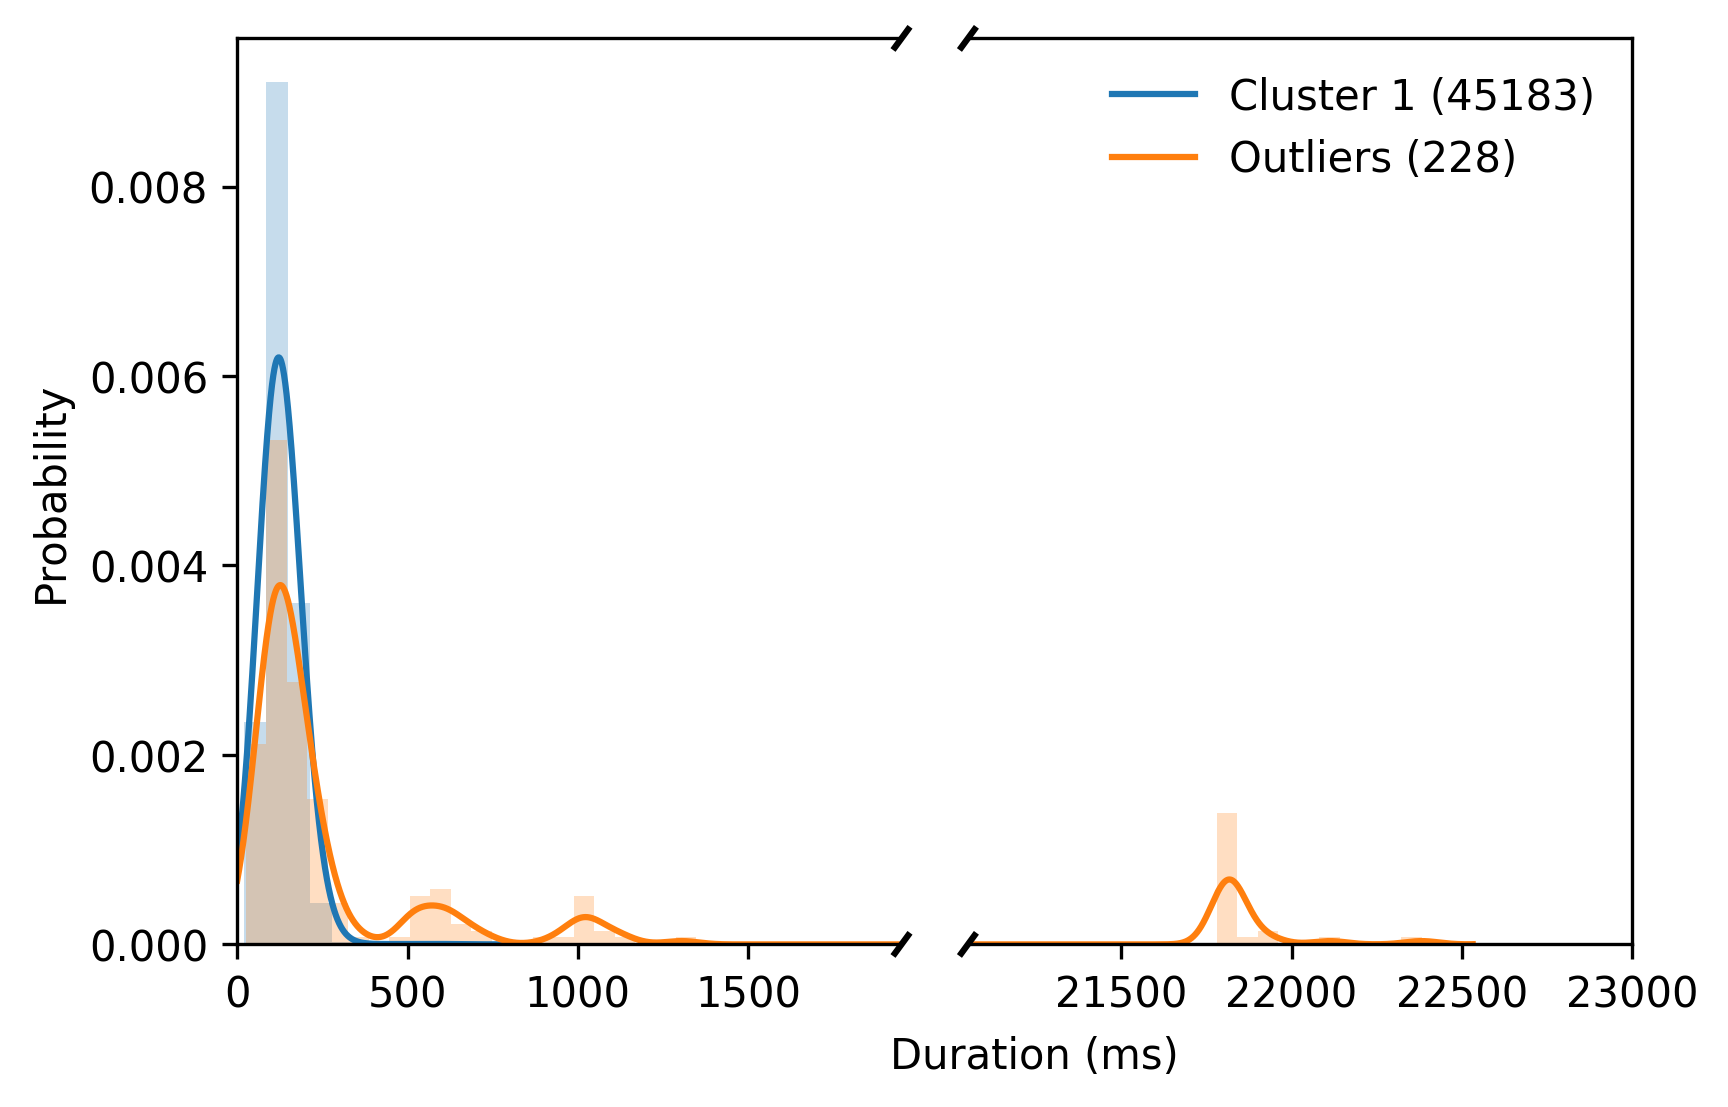

array([-1,  0,  0, ...,  0,  0,  0])

In [15]:
model = DBSCAN(eps=25, min_samples=100, n_jobs=-1, algorithm='ball_tree')
pipeline(states, duration, model, bow=True, name="features_bow")


--------------------------------------------------
Cluster 0
--------------------------------------------------
	Size                :      45183

Duration:
	Min                 :      20.50 ms
	Max                 :    1135.62 ms
	Median              :     122.46 ms
	Mean                :     126.88 ms
	Std                 :      44.47 ms

Probabilities
	P(duration > 200ms) :     5.161%
	P(duration > 250ms) :     0.808%
	P(duration > 300ms) :     0.206%

--------------------------------------------------
Cluster 1
--------------------------------------------------
	Size                :        228

Duration:
	Min                 :      22.01 ms
	Max                 :   22381.73 ms
	Median              :      81.24 ms
	Mean                :    2572.02 ms
	Std                 :    6762.59 ms

Probabilities
	P(duration > 200ms) :    34.649%
	P(duration > 250ms) :    28.947%
	P(duration > 300ms) :    26.754%



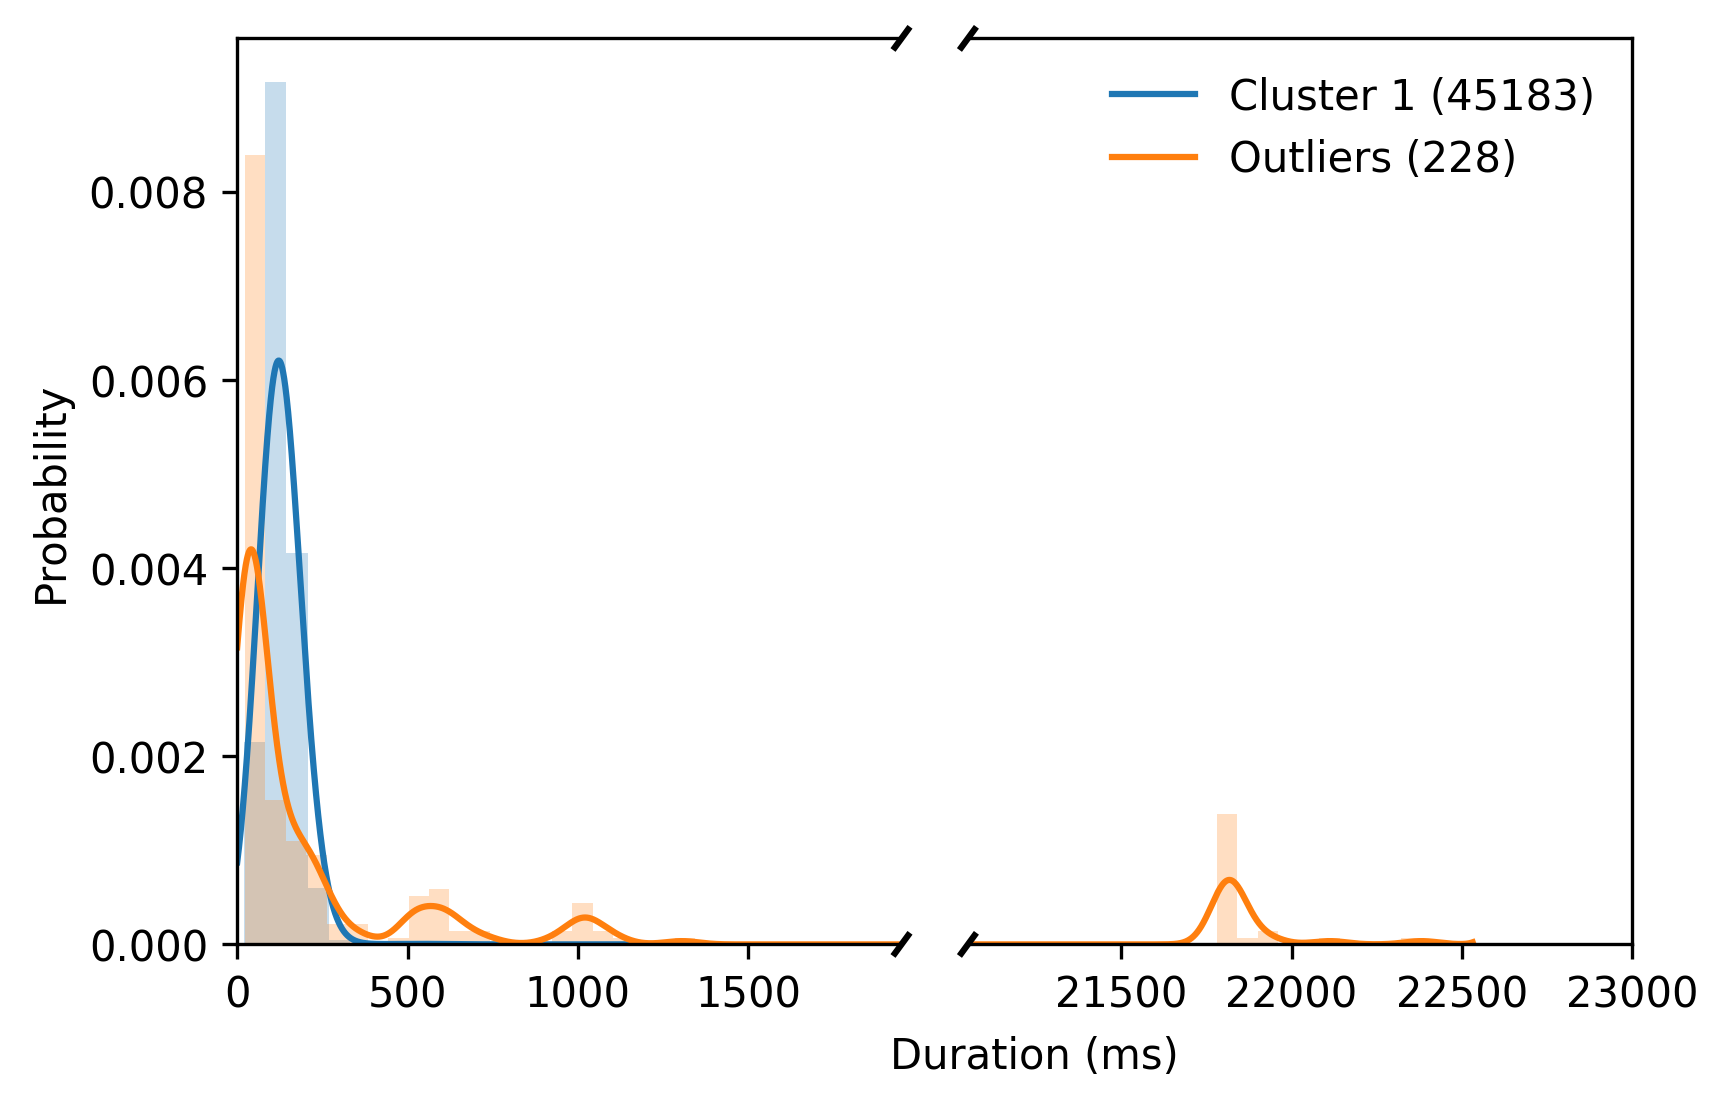

array([-1,  1,  1, ...,  1,  1,  1])

In [16]:
model = IsolationForest(
    n_estimators=250,
    contamination=0.005,
    behaviour='new',
    max_features=1.0,
    n_jobs=-1)
pipeline(states, duration, model, bow=True)


## 4.4 Based on Features count (TF-IDF)

--------------------------------------------------
Cluster 0
--------------------------------------------------
	Size                :        955

Duration:
	Min                 :      20.50 ms
	Max                 :     524.66 ms
	Median              :      76.10 ms
	Mean                :      84.79 ms
	Std                 :      52.53 ms

Probabilities
	P(duration > 200ms) :     1.780%
	P(duration > 250ms) :     0.733%
	P(duration > 300ms) :     0.628%

--------------------------------------------------
Cluster 1
--------------------------------------------------
	Size                :      44220

Duration:
	Min                 :      22.19 ms
	Max                 :     728.33 ms
	Median              :     123.00 ms
	Mean                :     127.53 ms
	Std                 :      43.66 ms

Probabilities
	P(duration > 200ms) :     5.206%
	P(duration > 250ms) :     0.796%
	P(duration > 300ms) :     0.192%

--------------------------------------------------
Cluster 2
-------------------

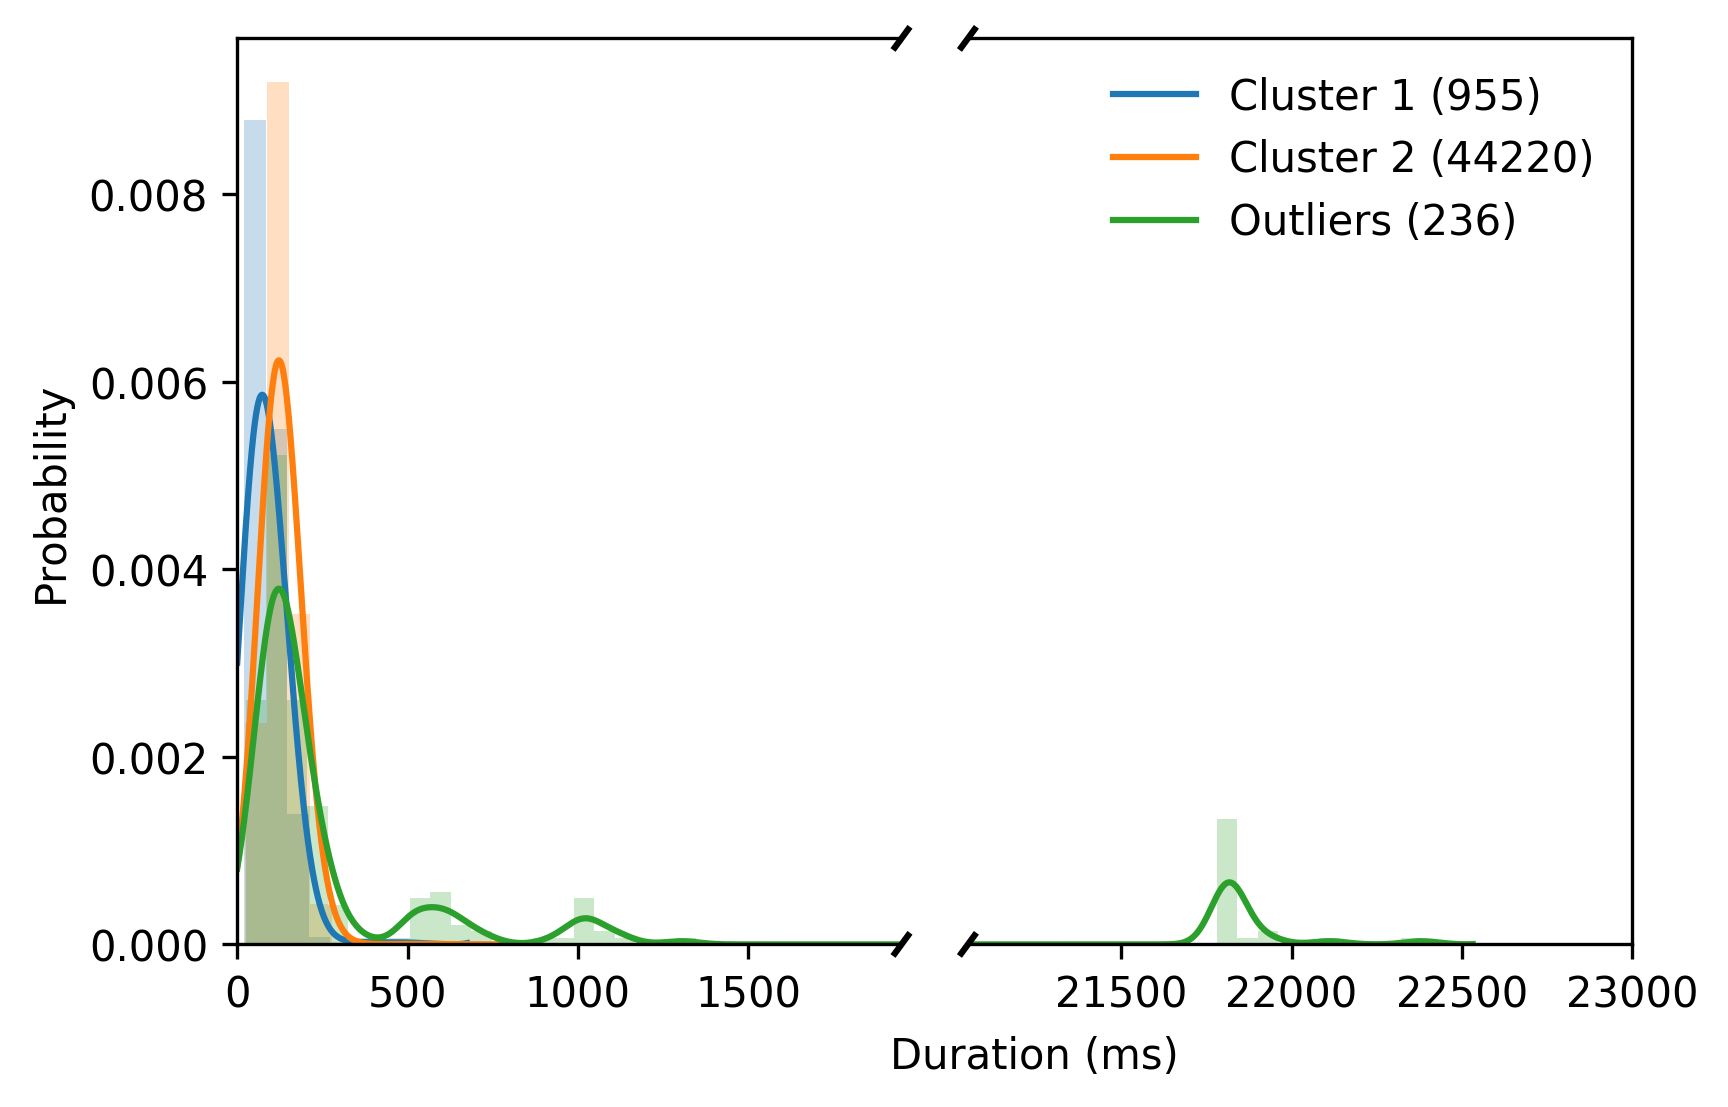

array([-1,  0,  1, ...,  1,  1,  1])

In [17]:
model = DBSCAN(eps=5e-4, min_samples=50, n_jobs=-1, algorithm='ball_tree')
pipeline(states, duration, model, tfidf=True, name="features_tfidf")


--------------------------------------------------
Cluster 0
--------------------------------------------------
	Size                :      45183

Duration:
	Min                 :      20.50 ms
	Max                 :     728.33 ms
	Median              :     122.43 ms
	Mean                :     126.81 ms
	Std                 :      44.19 ms

Probabilities
	P(duration > 200ms) :     5.157%
	P(duration > 250ms) :     0.801%
	P(duration > 300ms) :     0.201%

--------------------------------------------------
Cluster 1
--------------------------------------------------
	Size                :        228

Duration:
	Min                 :      23.04 ms
	Max                 :   22381.73 ms
	Median              :     105.32 ms
	Mean                :    2584.04 ms
	Std                 :    6758.60 ms

Probabilities
	P(duration > 200ms) :    35.526%
	P(duration > 250ms) :    30.263%
	P(duration > 300ms) :    27.632%



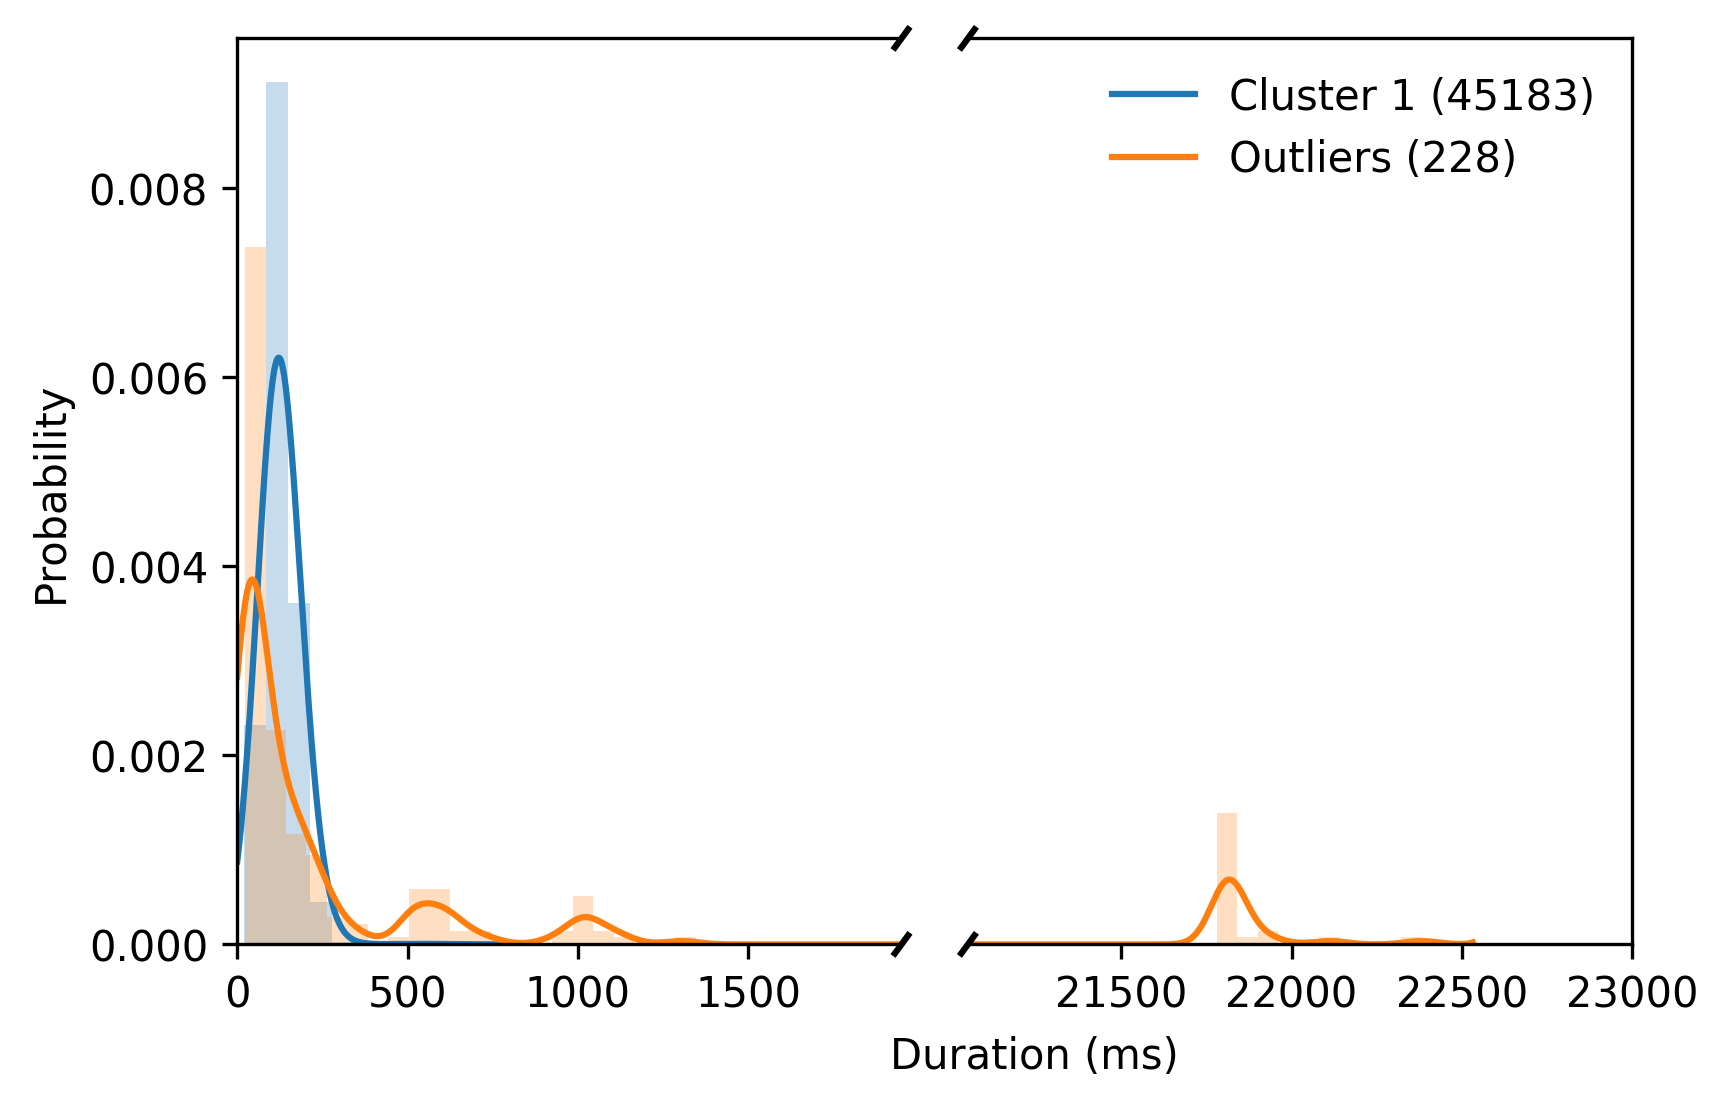

array([-1,  1,  1, ...,  1,  1,  1])

In [18]:
model = IsolationForest(
    n_estimators=250,
    contamination=0.005,
    behaviour='new',
    max_features=1.0,
    n_jobs=-1)
pipeline(states, duration, model, tfidf=True)


## 4.4 Based on Features duration

--------------------------------------------------
Cluster 0
--------------------------------------------------
	Size                :      45254

Duration:
	Min                 :      20.50 ms
	Max                 :     323.83 ms
	Median              :     122.22 ms
	Mean                :     126.00 ms
	Std                 :      41.45 ms

Probabilities
	P(duration > 200ms) :     4.992%
	P(duration > 250ms) :     0.632%
	P(duration > 300ms) :     0.031%

--------------------------------------------------
Cluster 1
--------------------------------------------------
	Size                :        157

Duration:
	Min                 :      78.20 ms
	Max                 :   22381.73 ms
	Median              :     553.67 ms
	Mean                :    3928.99 ms
	Std                 :    7791.94 ms

Probabilities
	P(duration > 200ms) :    96.815%
	P(duration > 250ms) :    92.357%
	P(duration > 300ms) :    89.172%



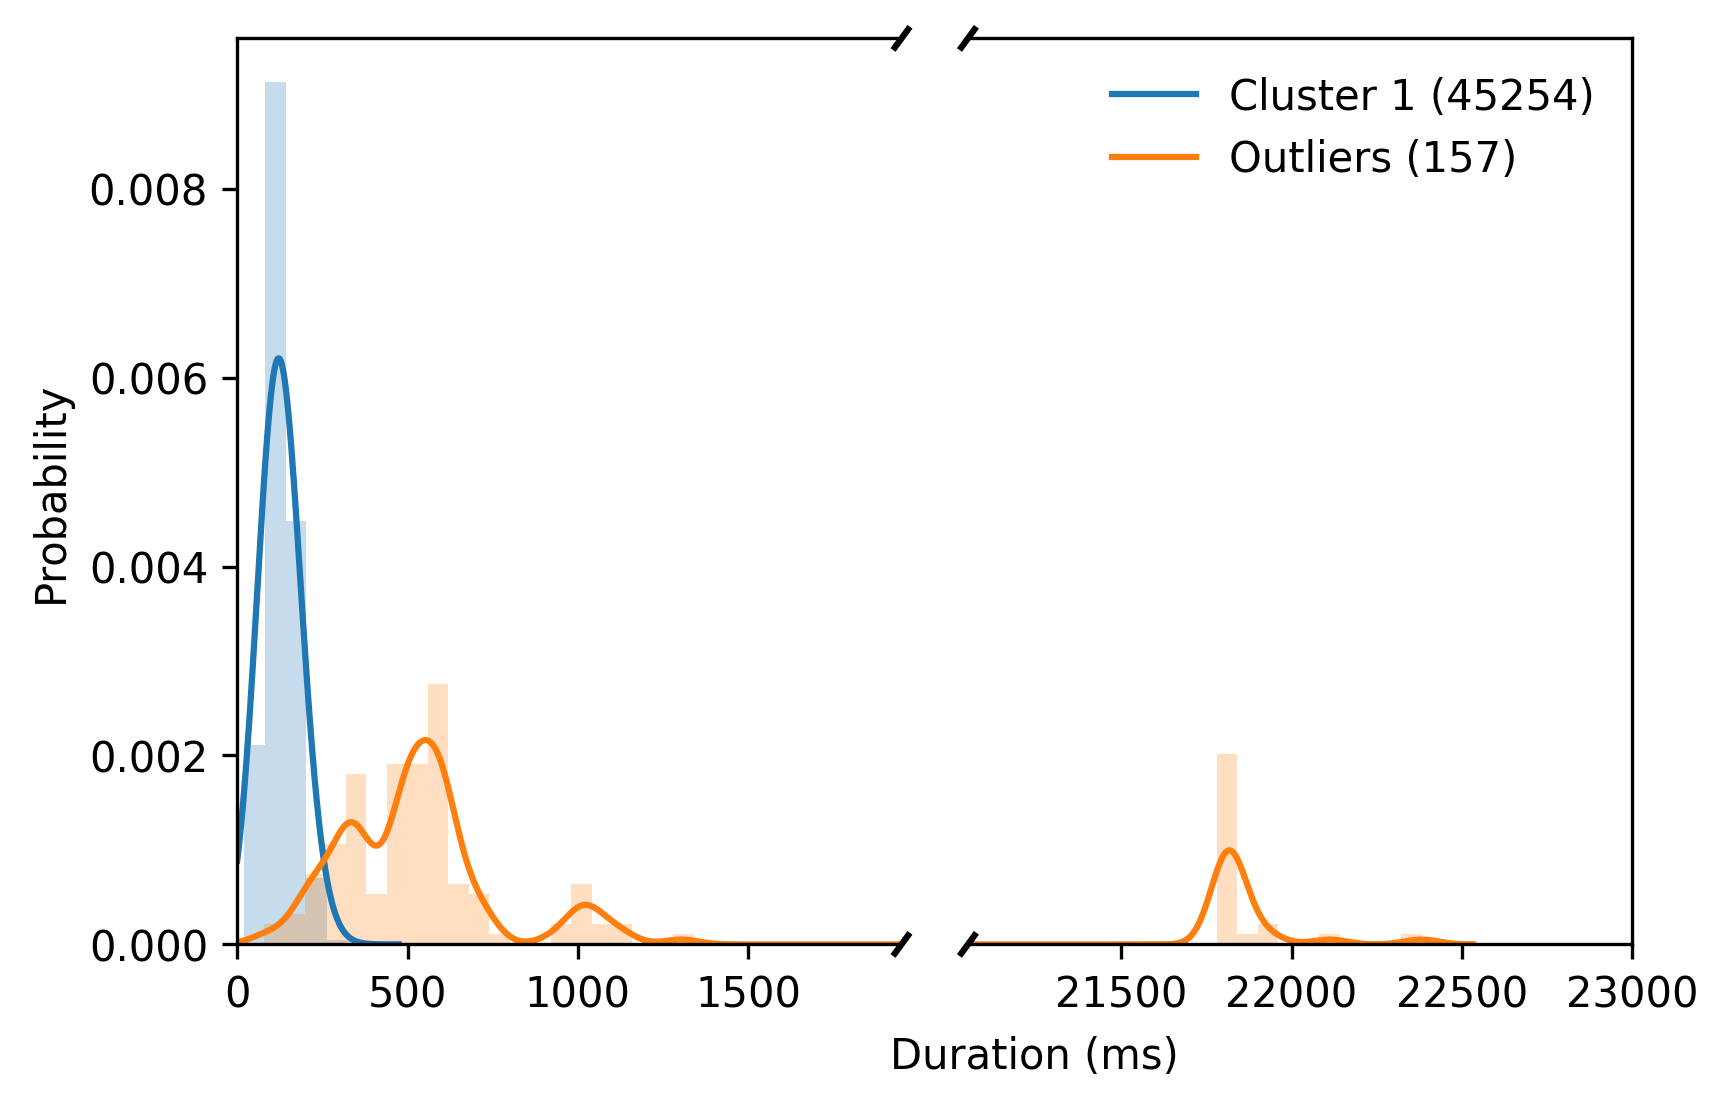

In [19]:
model = DBSCAN(eps=25, min_samples=100, n_jobs=-1, algorithm='ball_tree')
cluster = pipeline(times, duration, model, name="features_duration")


--------------------------------------------------
Cluster 0
--------------------------------------------------
	Size                :      45183

Duration:
	Min                 :      22.19 ms
	Max                 :    1135.62 ms
	Median              :     122.40 ms
	Mean                :     126.58 ms
	Std                 :      43.07 ms

Probabilities
	P(duration > 200ms) :     5.090%
	P(duration > 250ms) :     0.735%
	P(duration > 300ms) :     0.137%

--------------------------------------------------
Cluster 1
--------------------------------------------------
	Size                :        228

Duration:
	Min                 :      20.50 ms
	Max                 :   22381.73 ms
	Median              :     140.13 ms
	Mean                :    2631.50 ms
	Std                 :    6742.59 ms

Probabilities
	P(duration > 200ms) :    48.684%
	P(duration > 250ms) :    43.421%
	P(duration > 300ms) :    40.351%



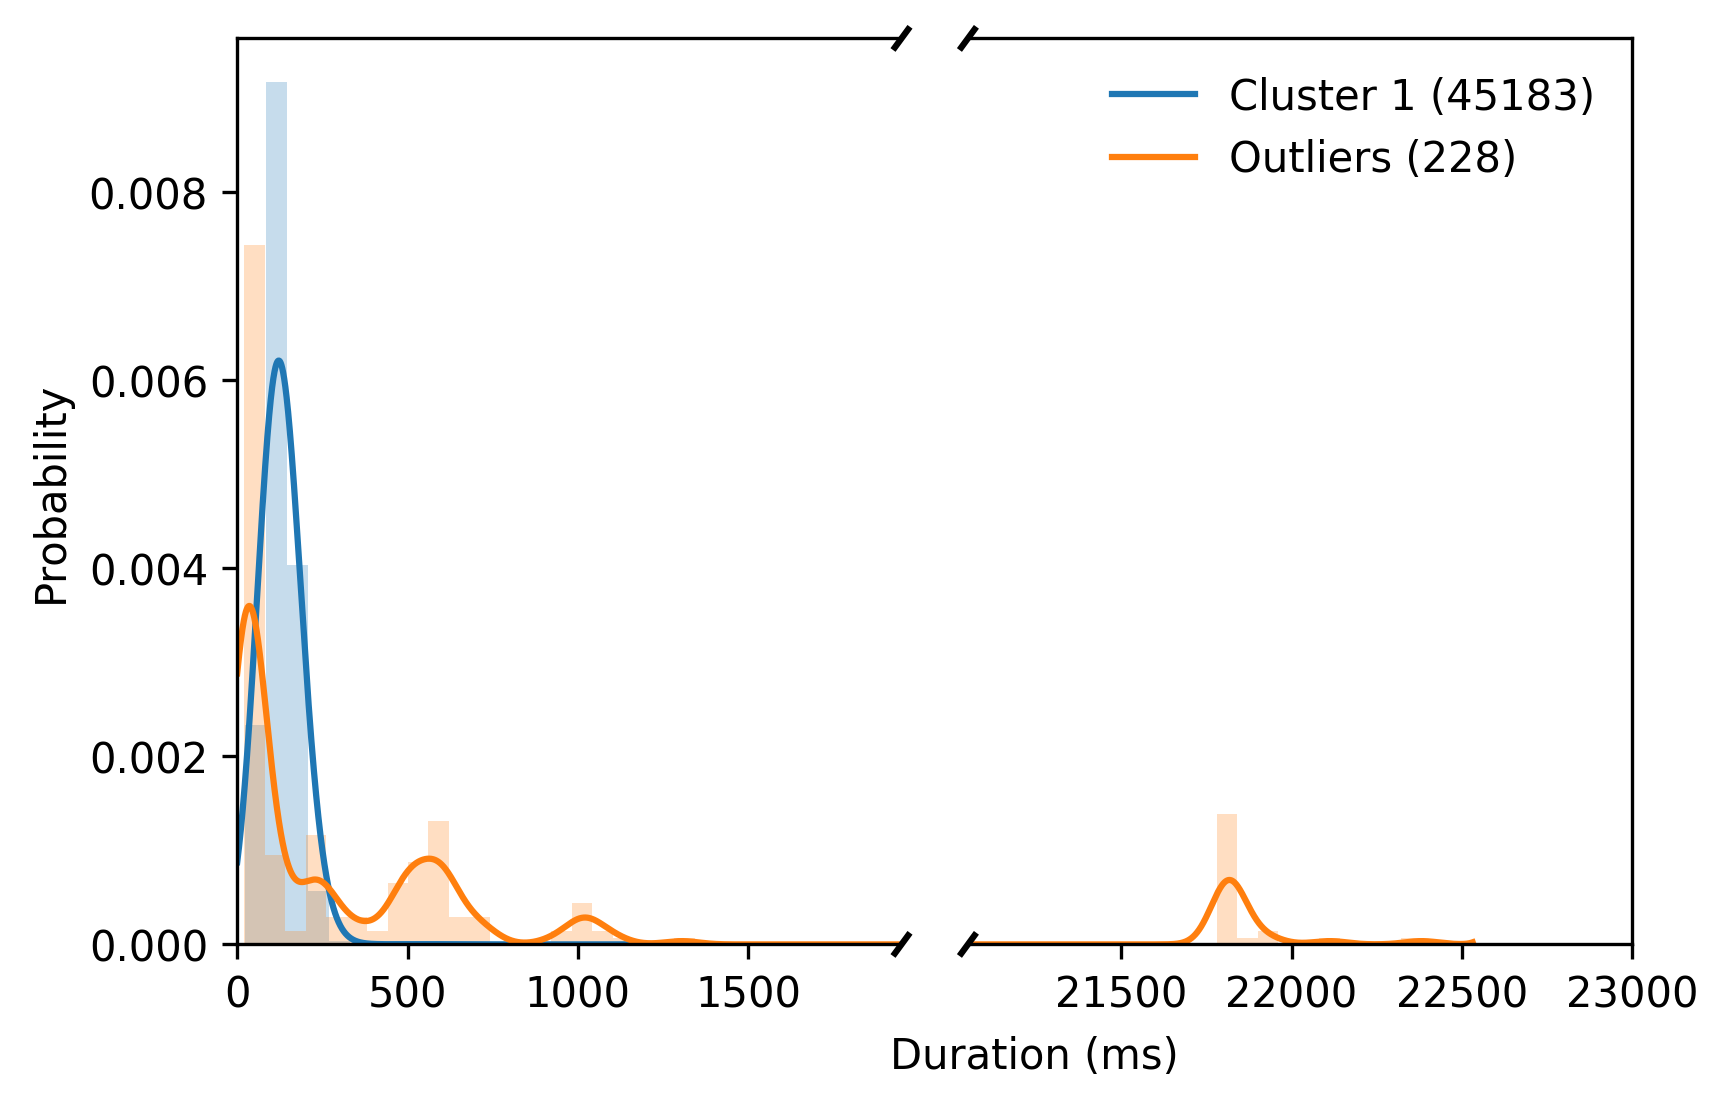

array([-1, -1,  1, ...,  1,  1,  1])

In [20]:
model = IsolationForest(
    n_estimators=250,
    contamination=0.005,
    behaviour='new',
    max_features=1.0,
    n_jobs=-1)
pipeline(times, duration, model)


# 5 Type of outliers

Cluster the outliers detected previously to see if there are groups (cpu, memory or disk limited requests)

In [21]:
from functions import ngram_statistics
from functions import cluster_outliers
from functions import seq2bow
from functions import split_clusters
from functions import statistics_clustering

from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

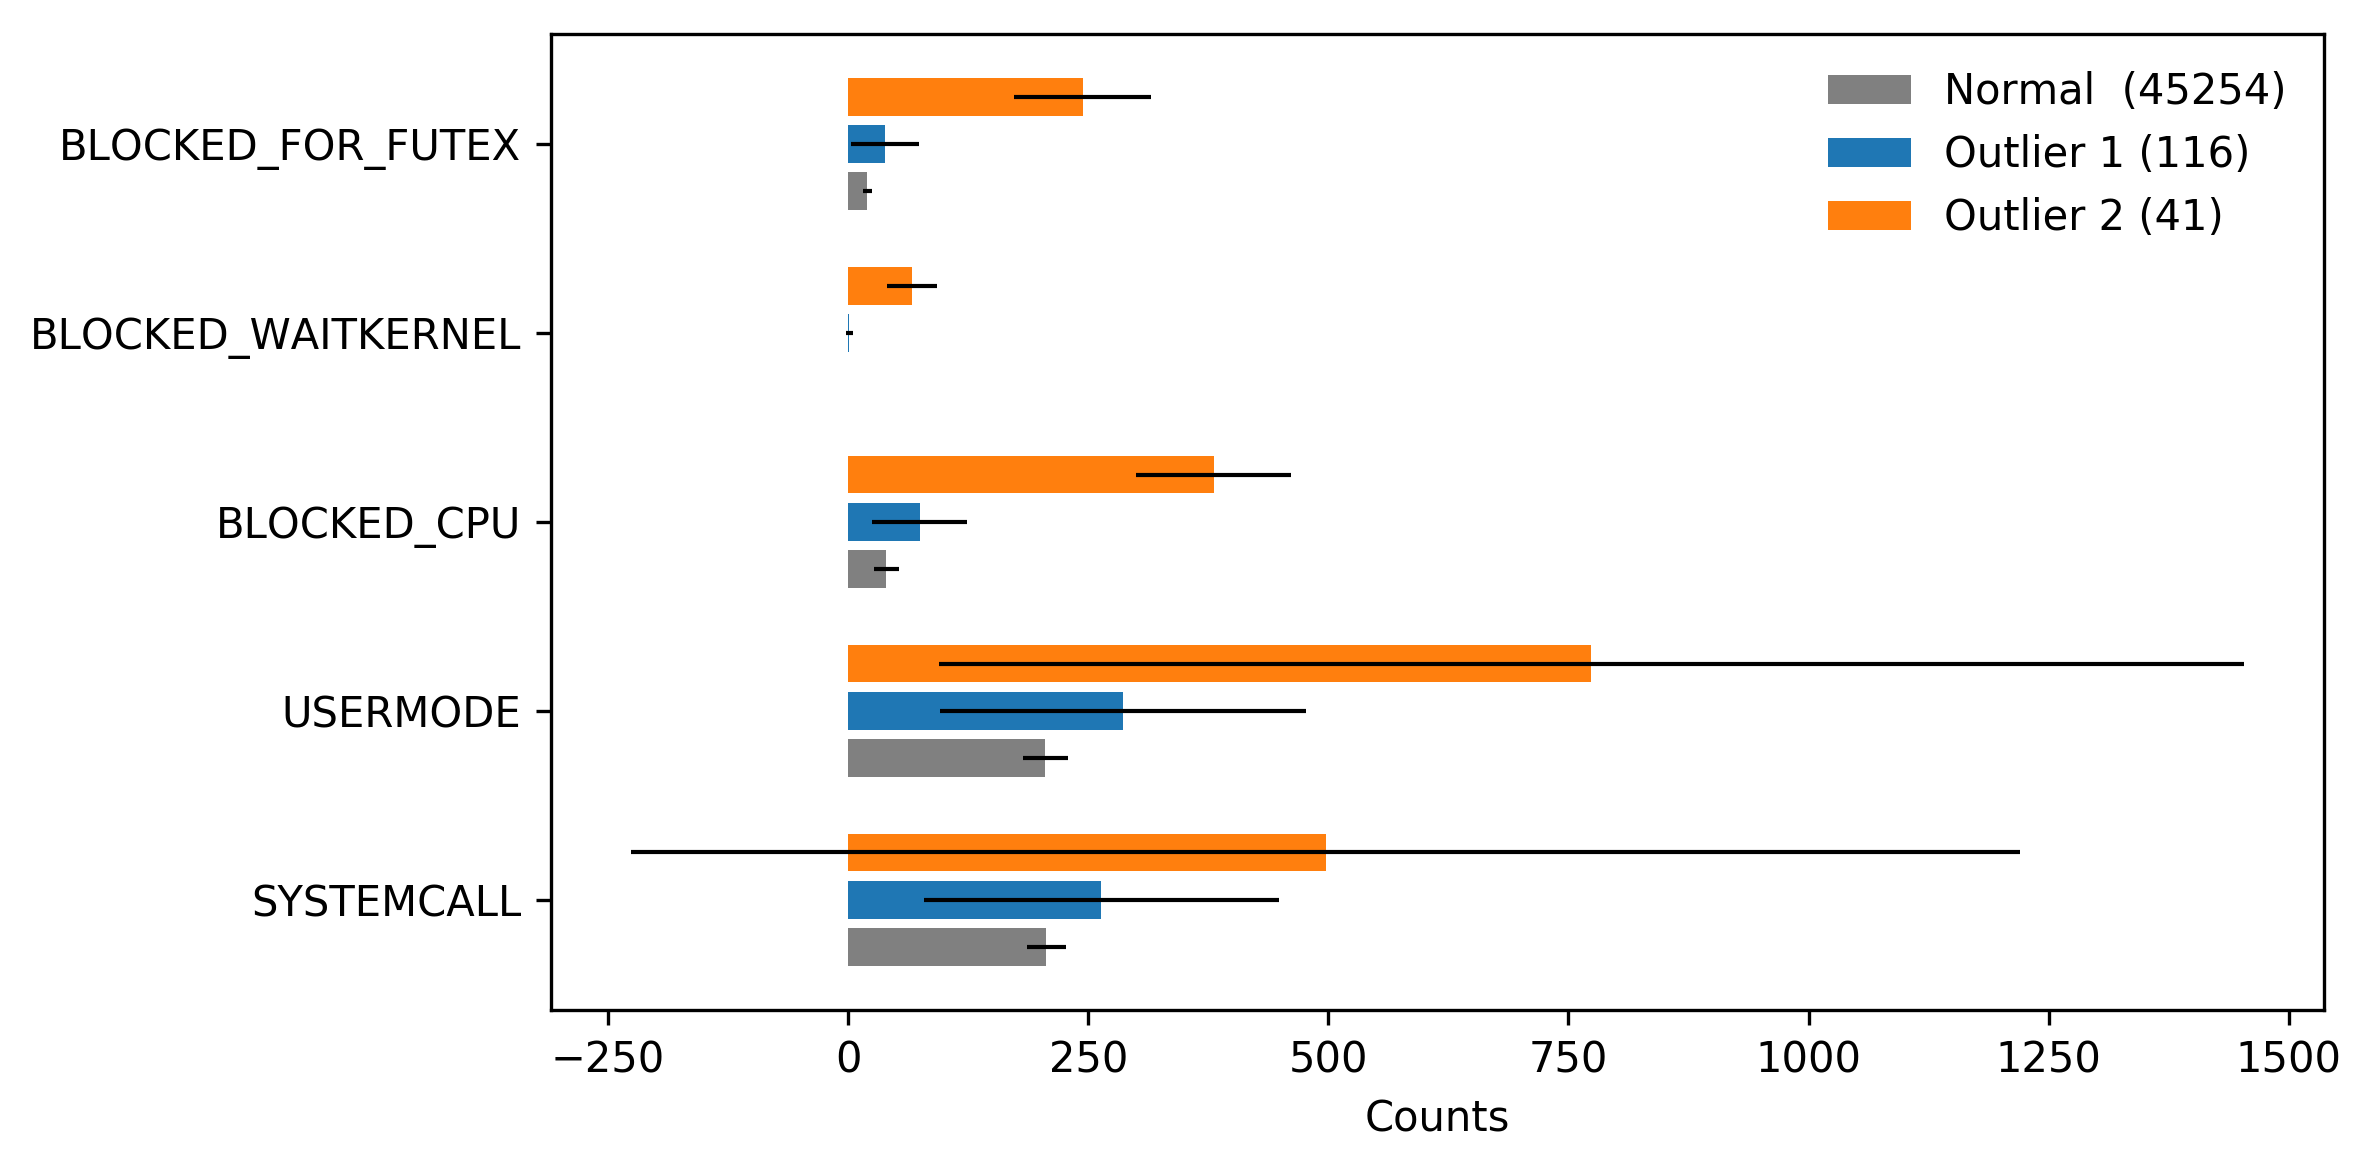

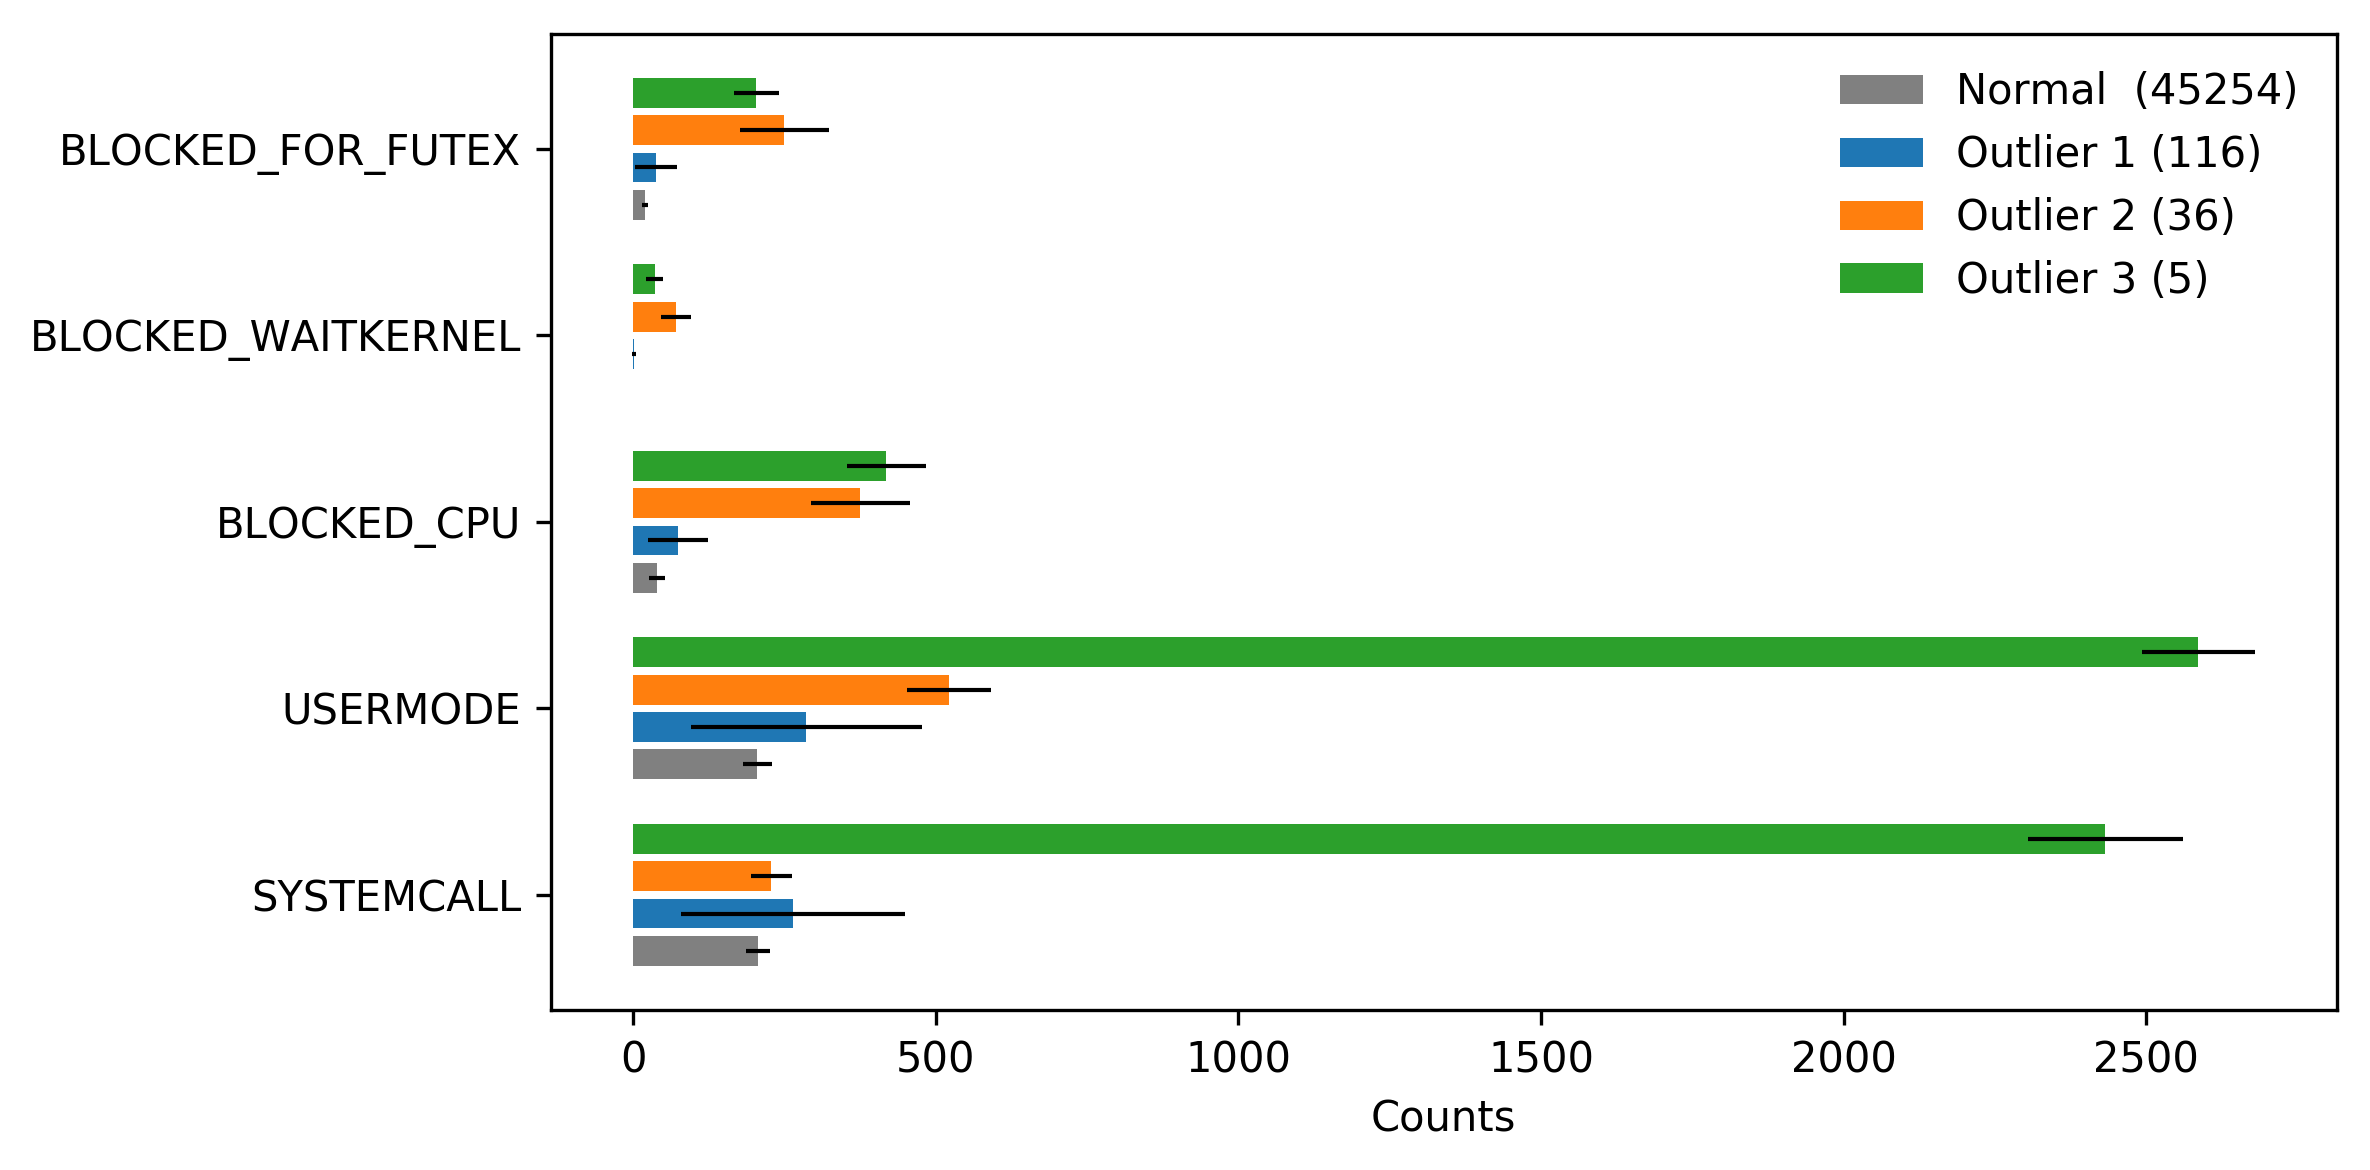

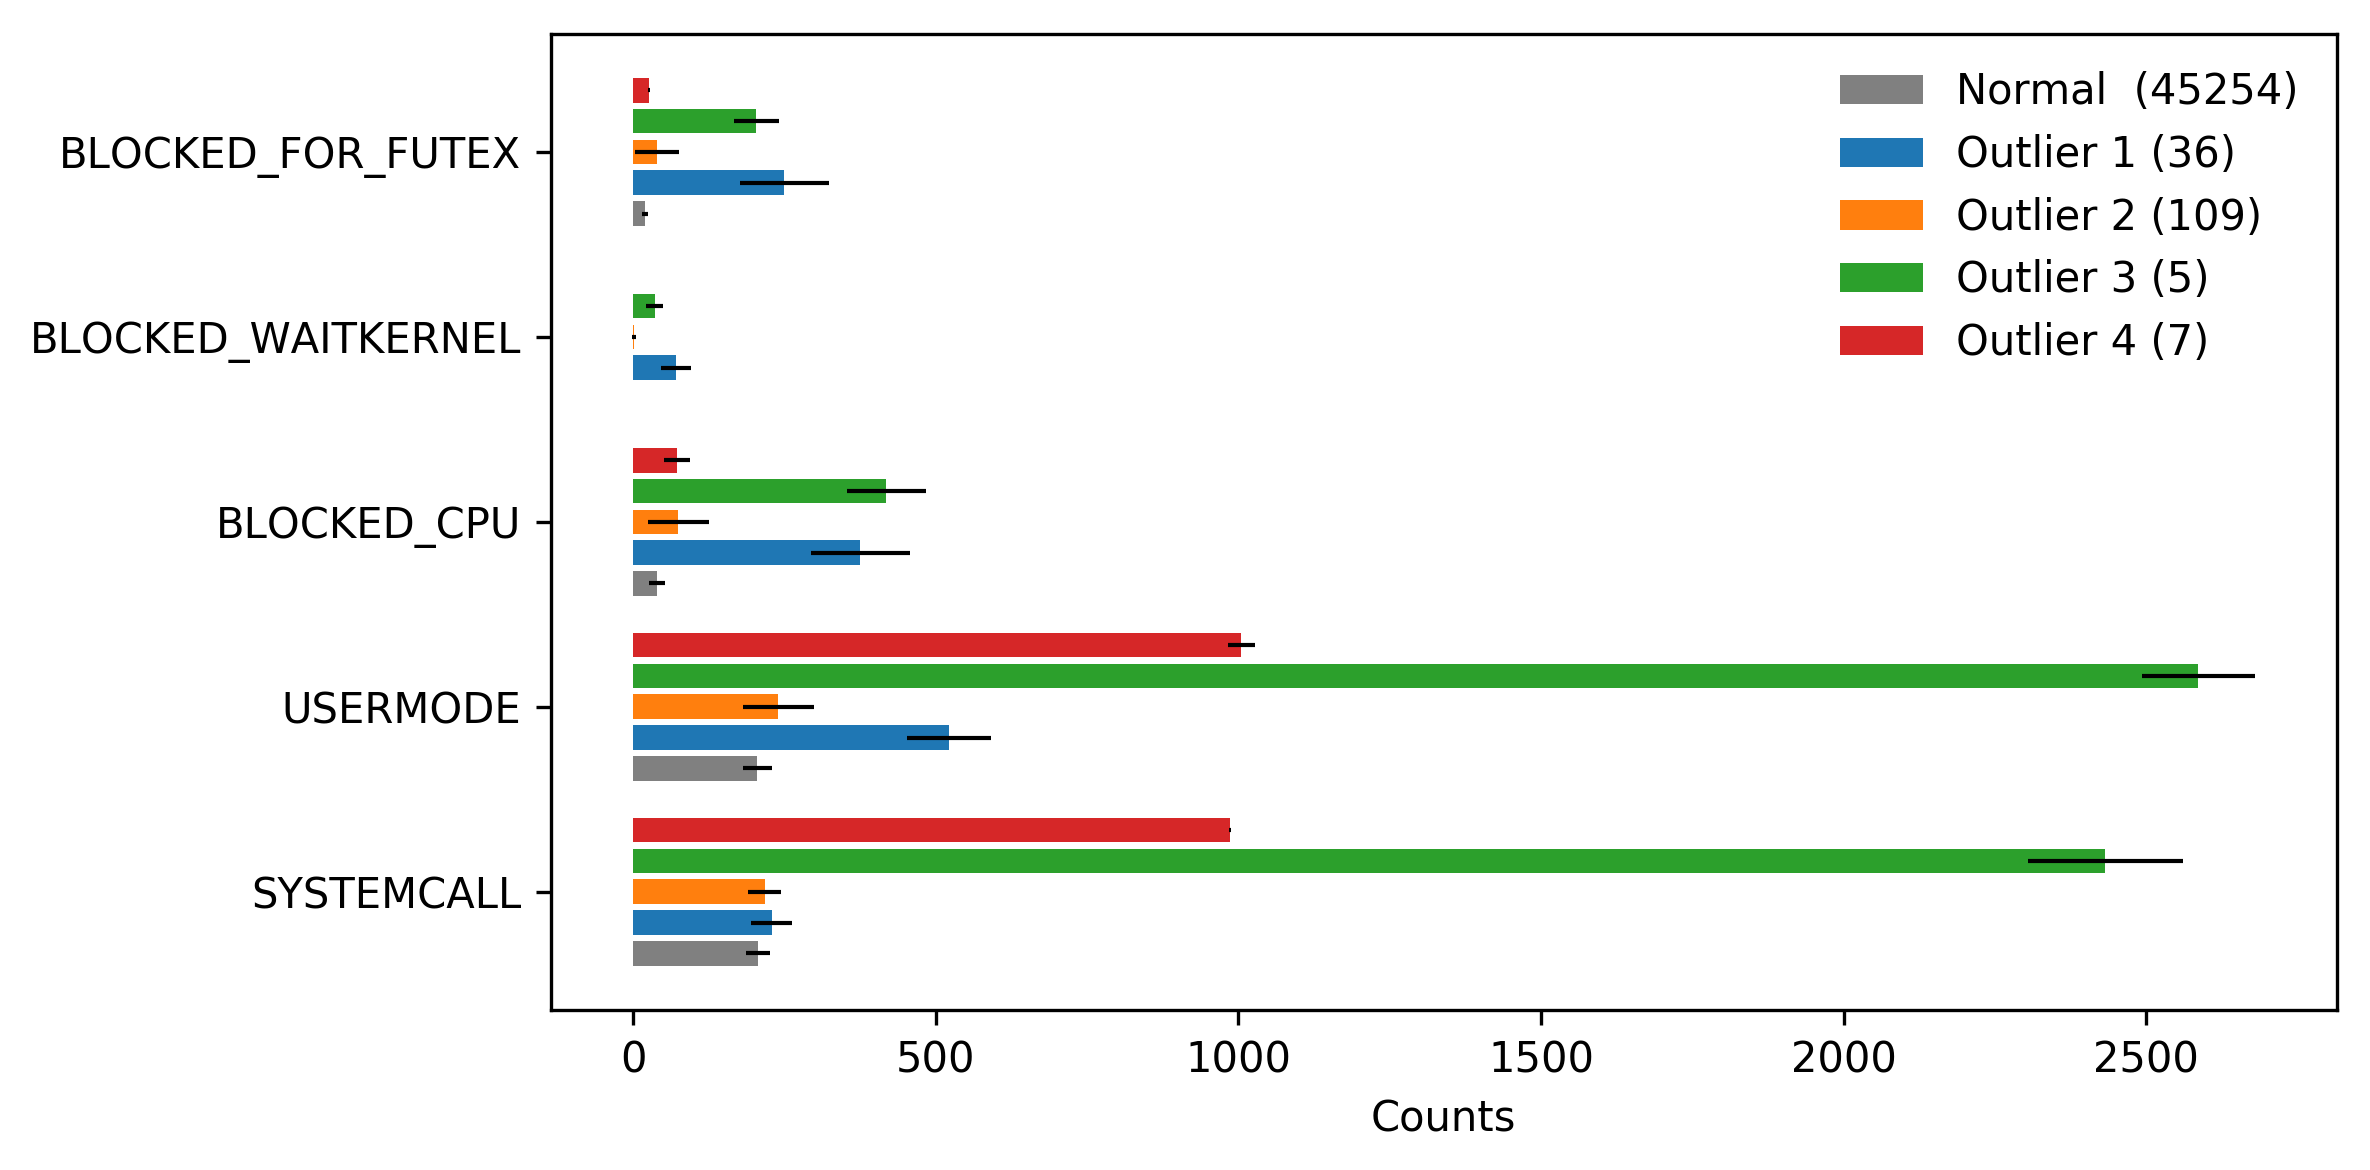

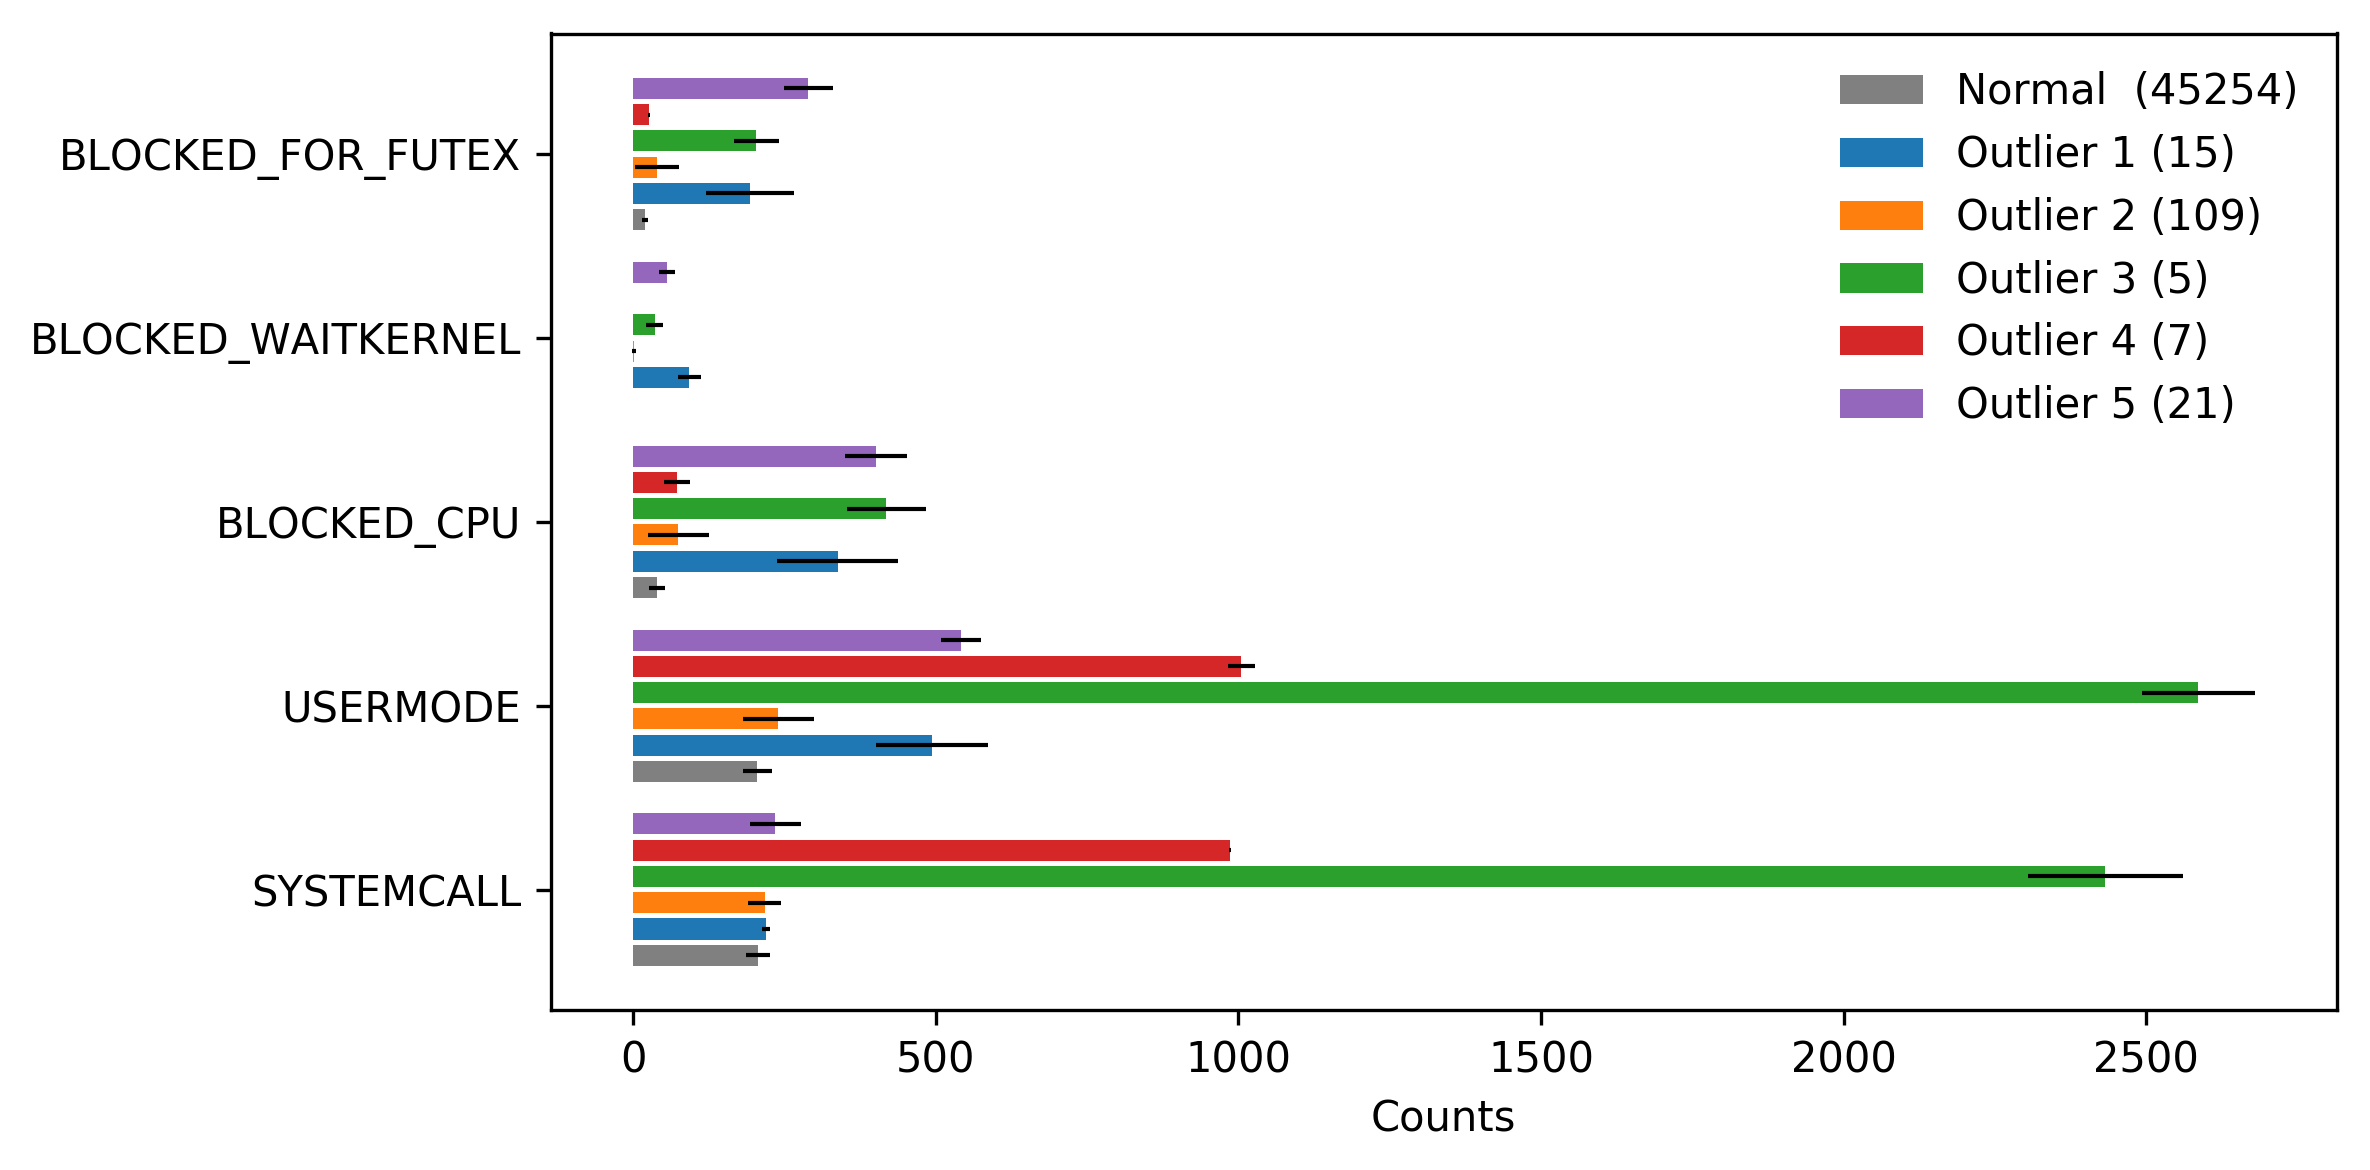

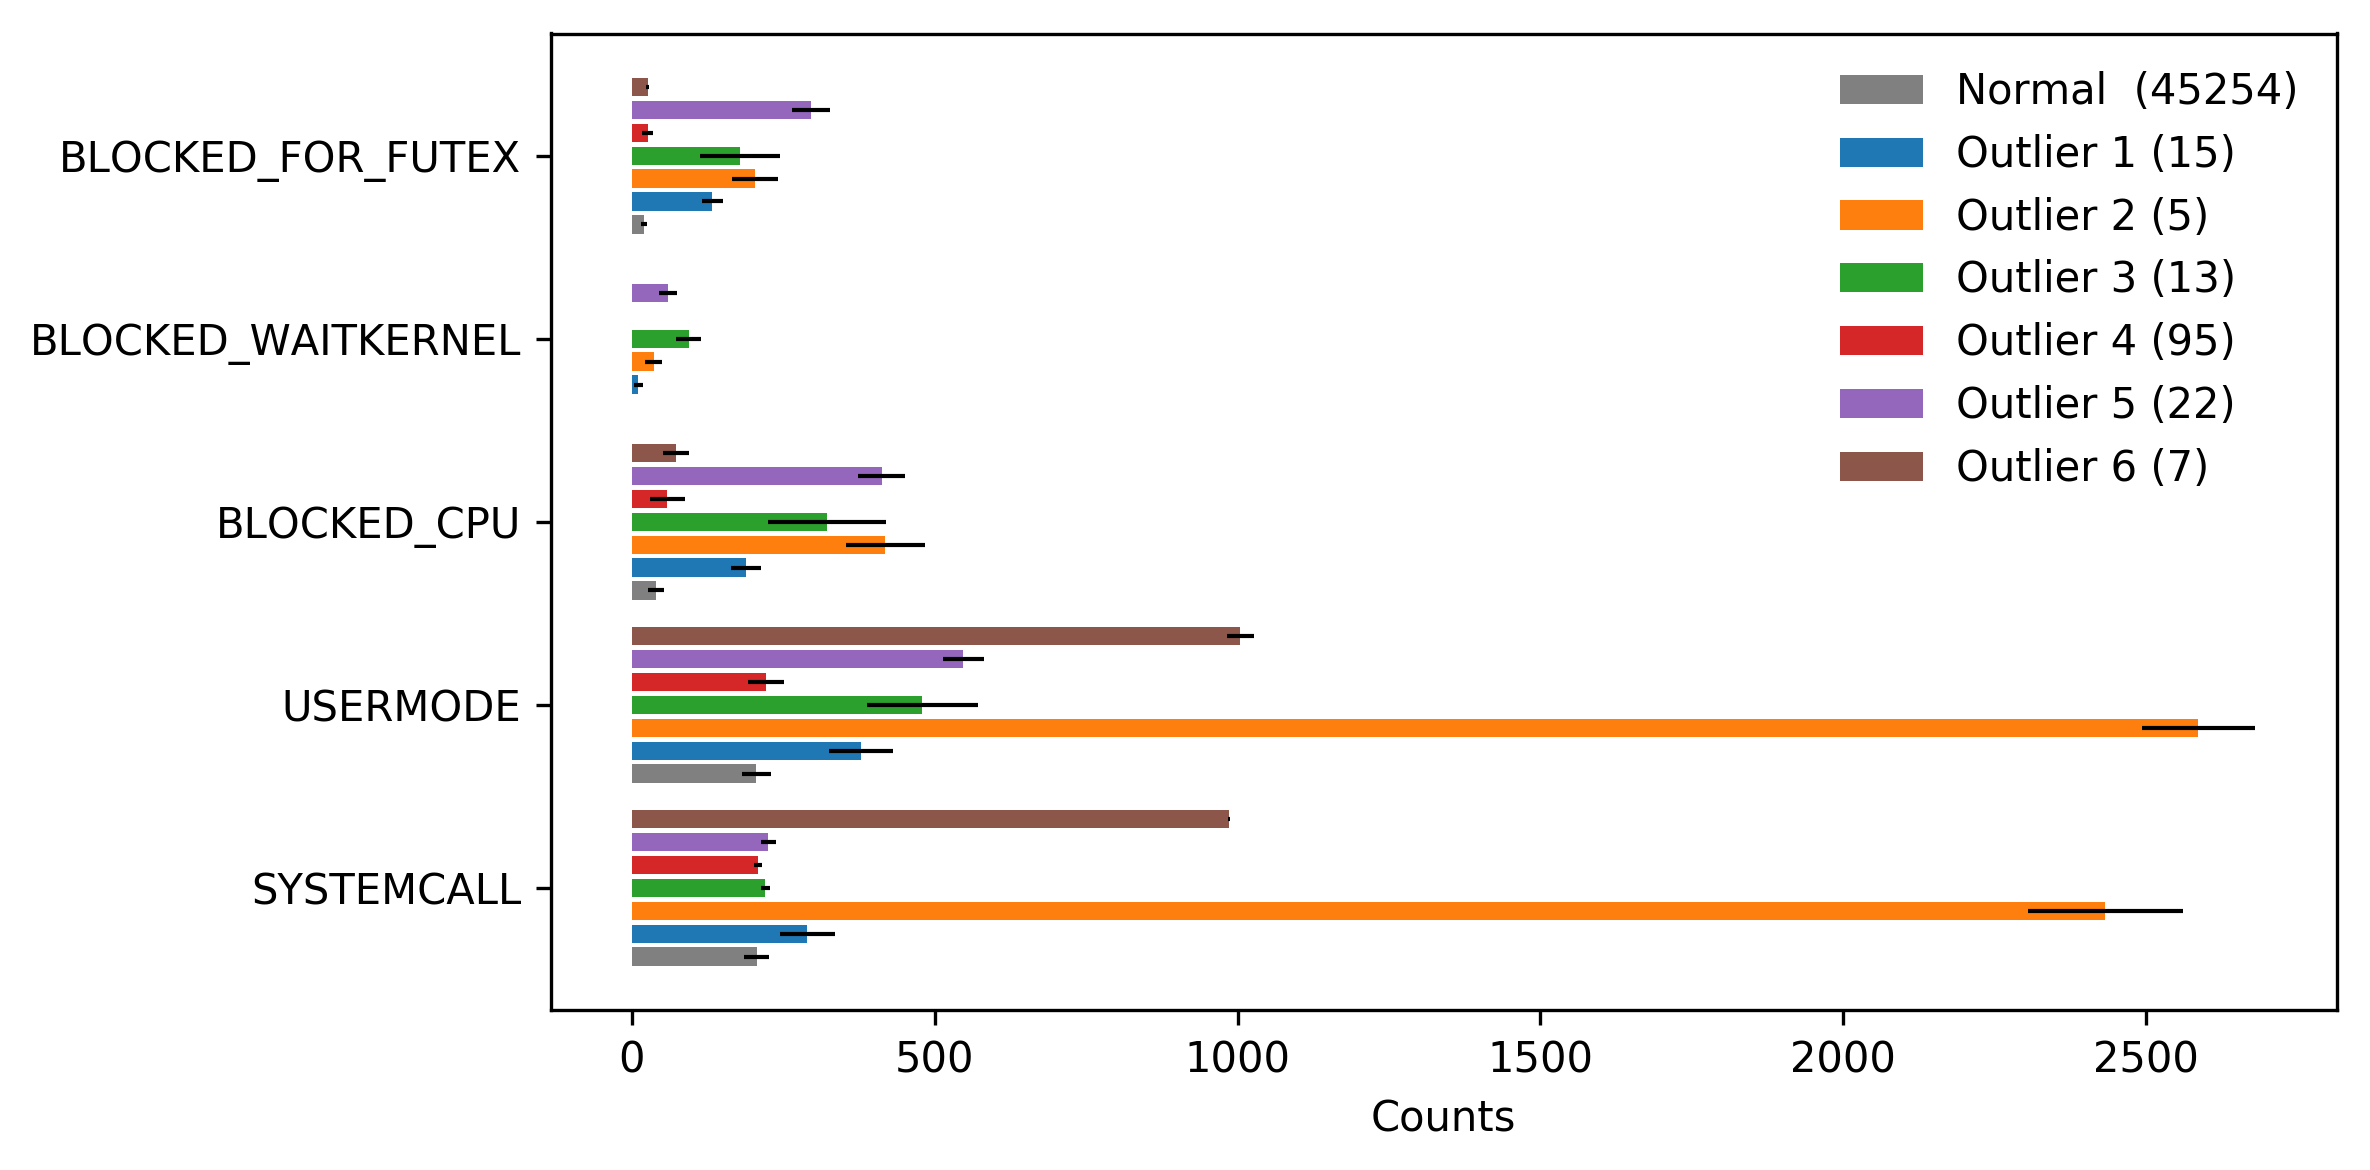

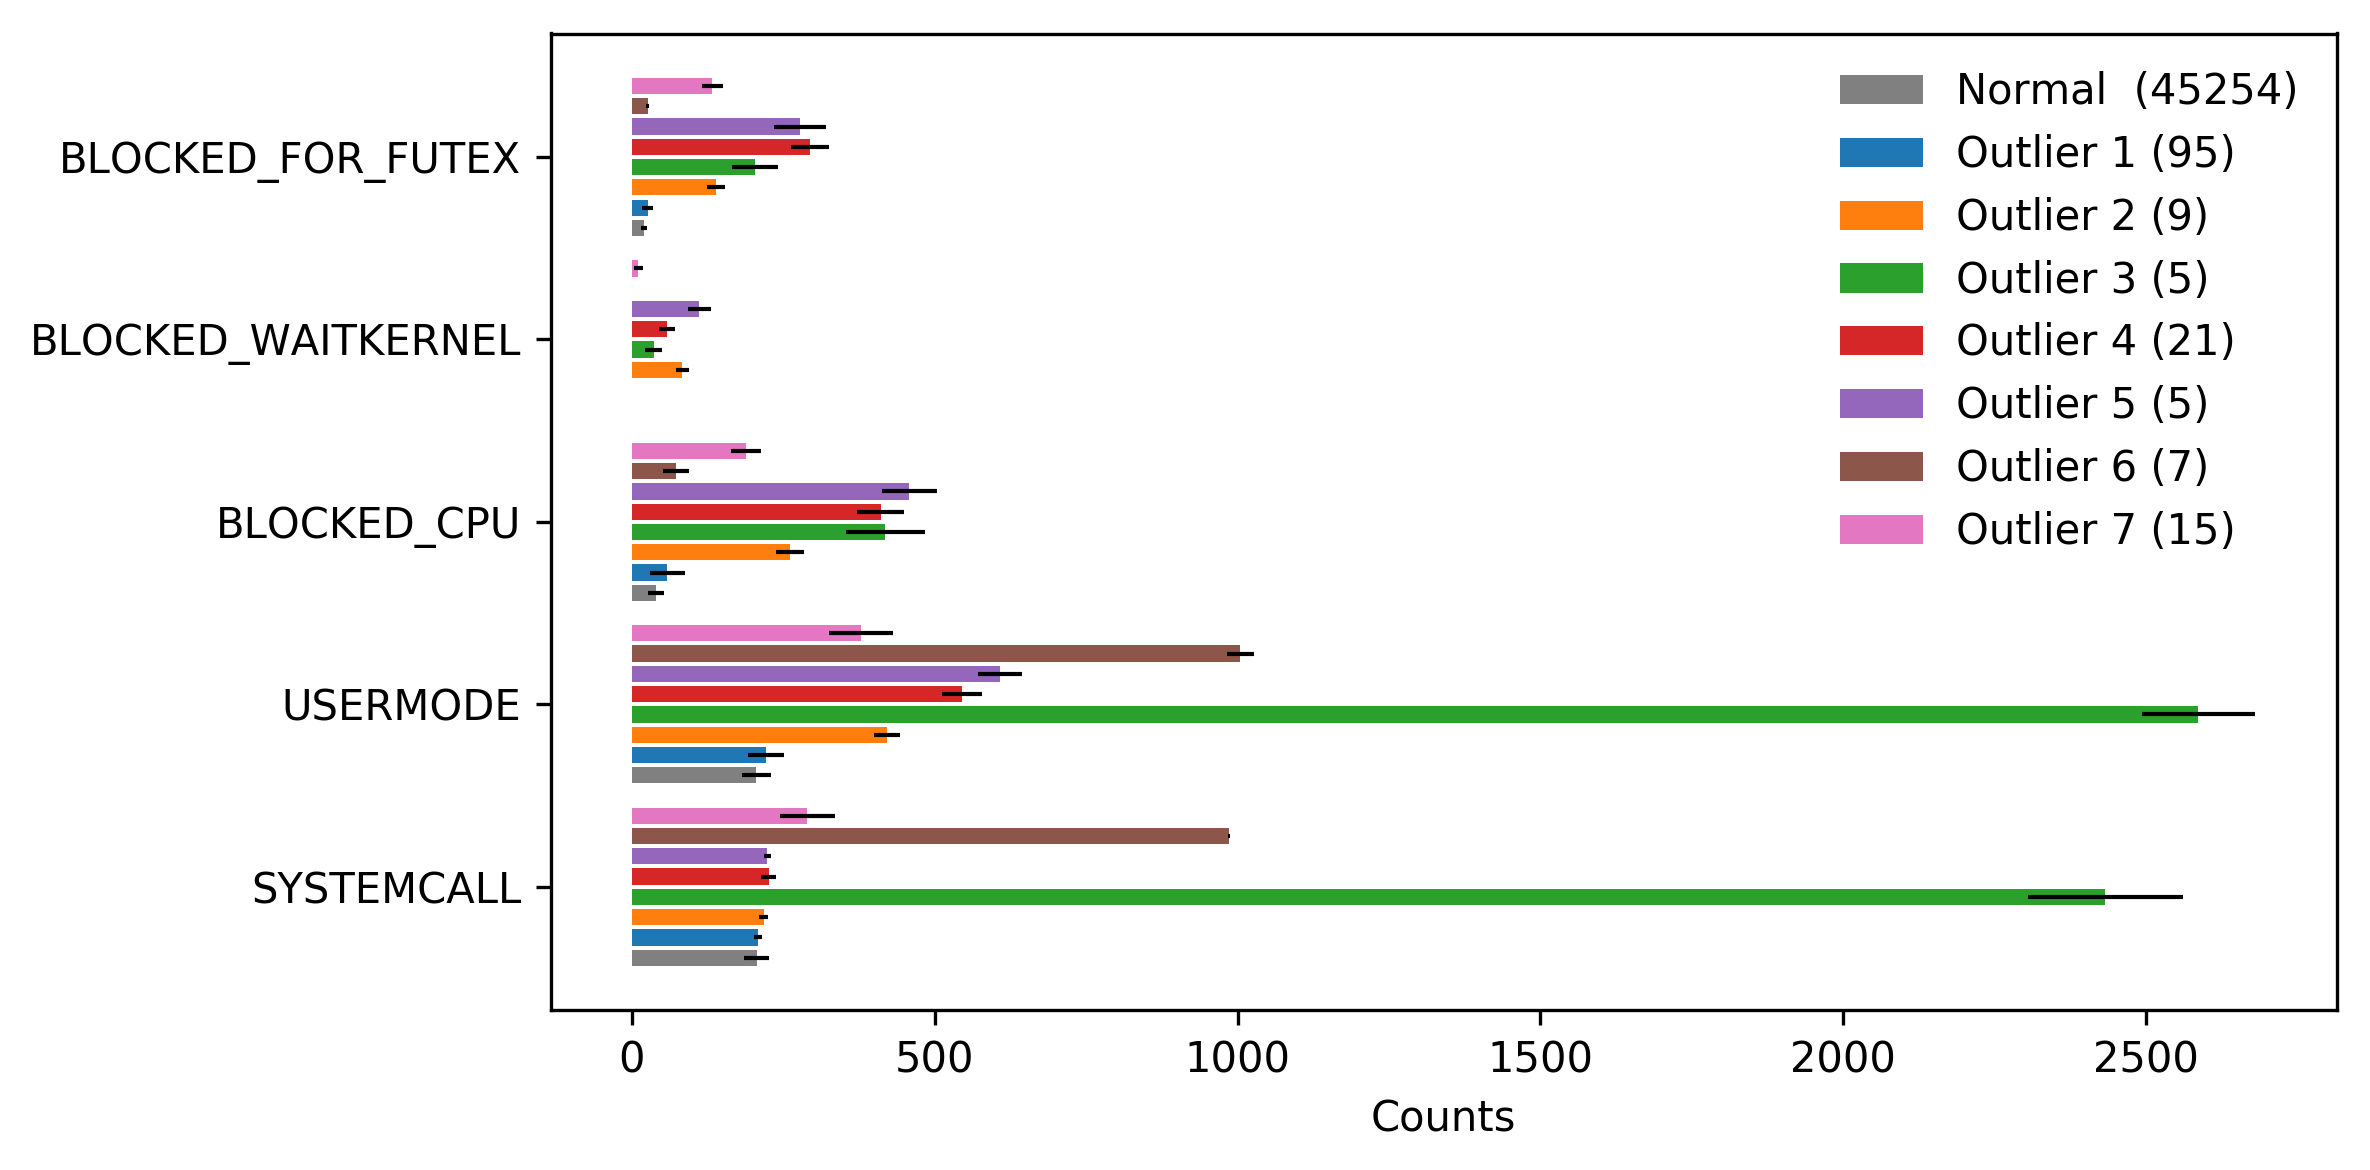

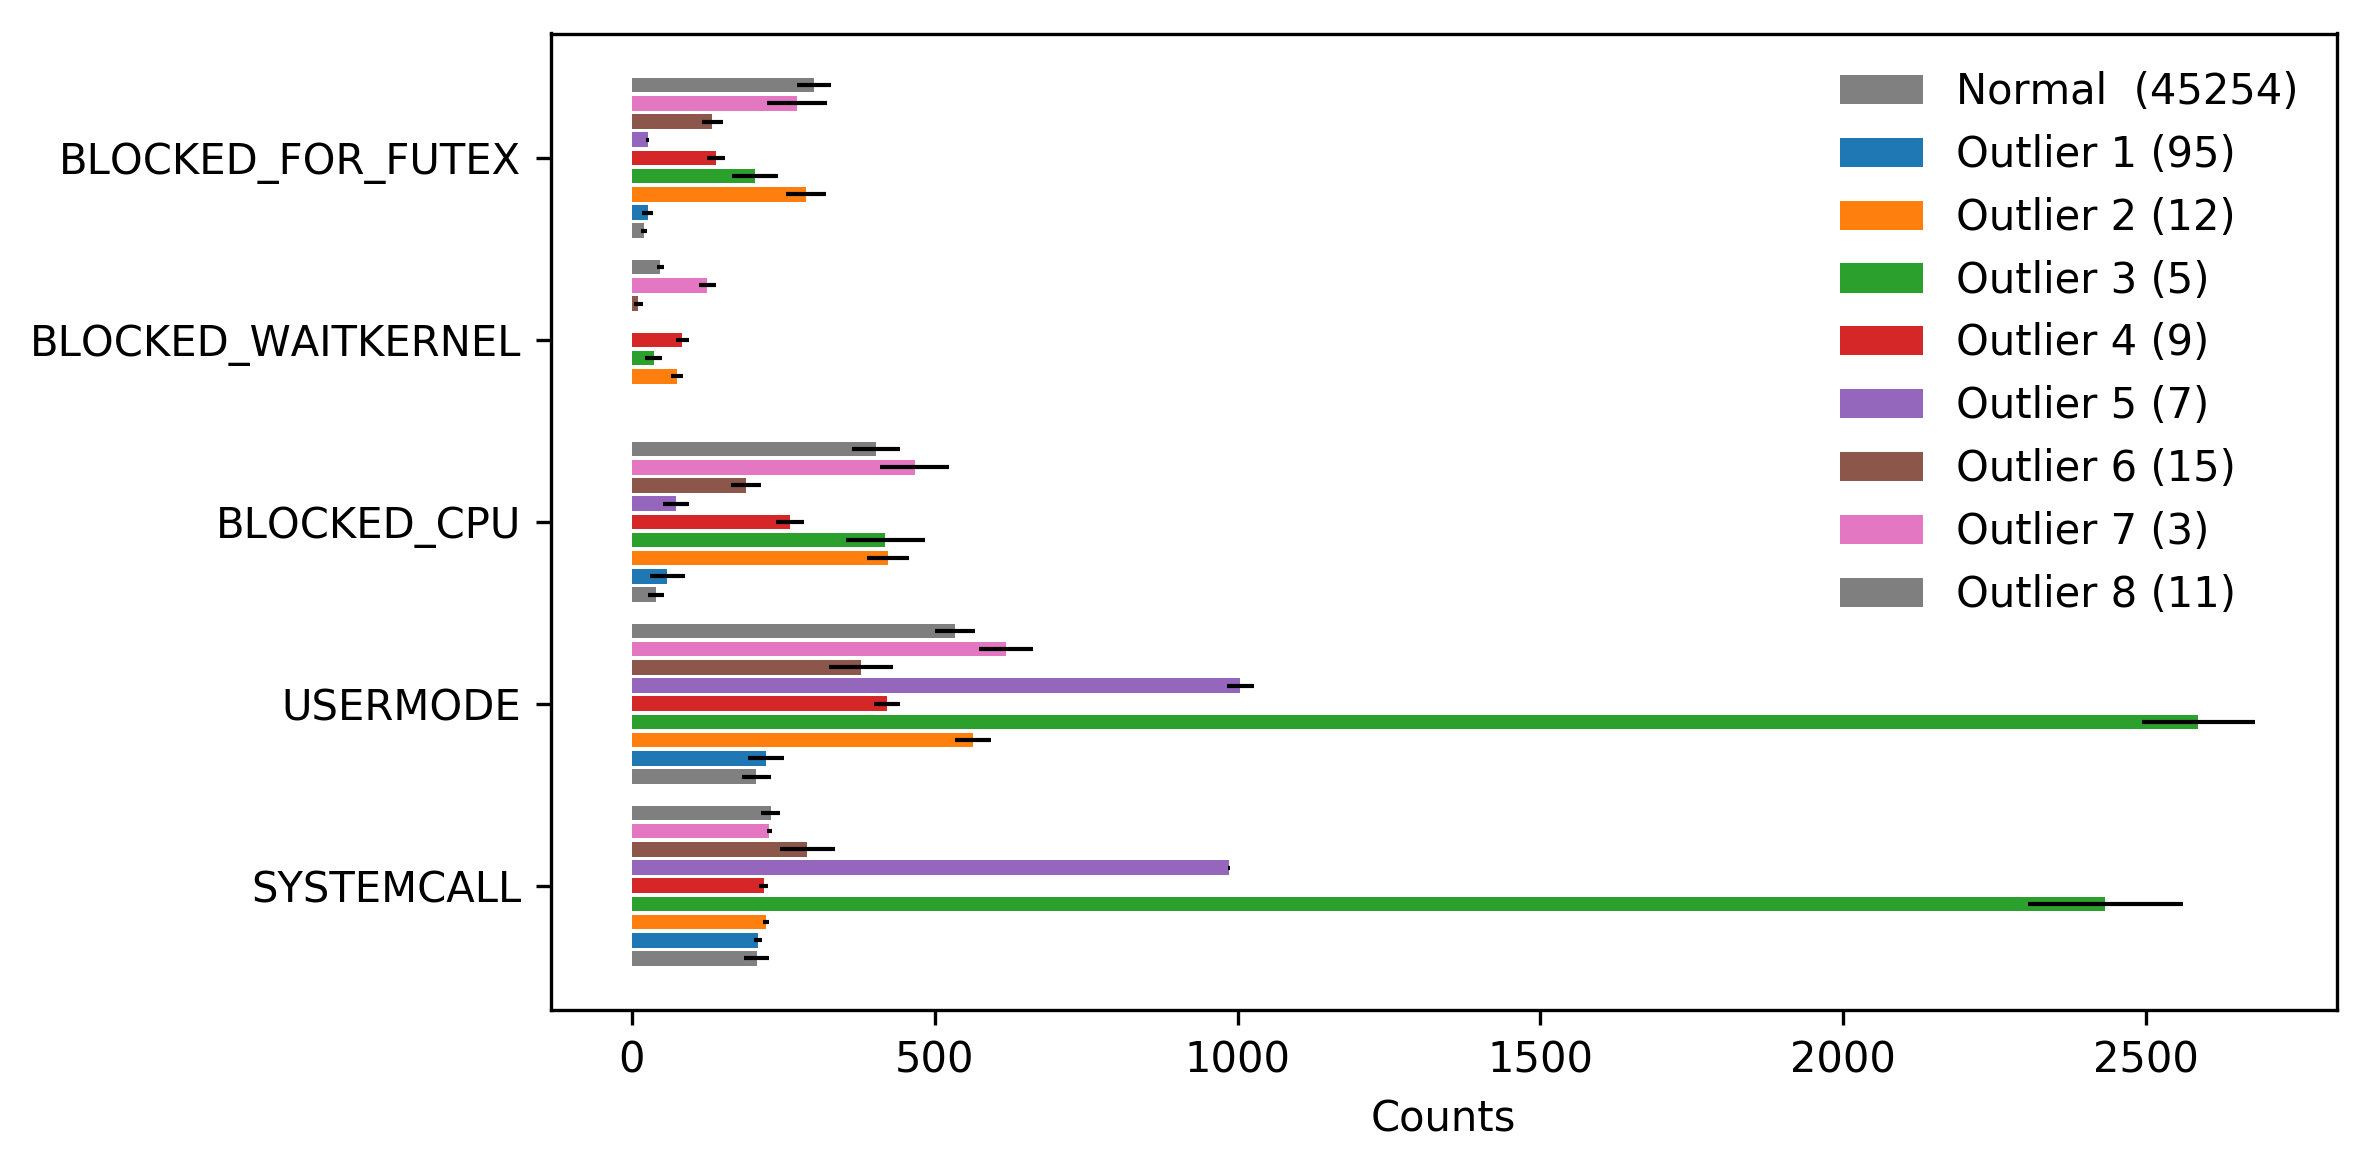

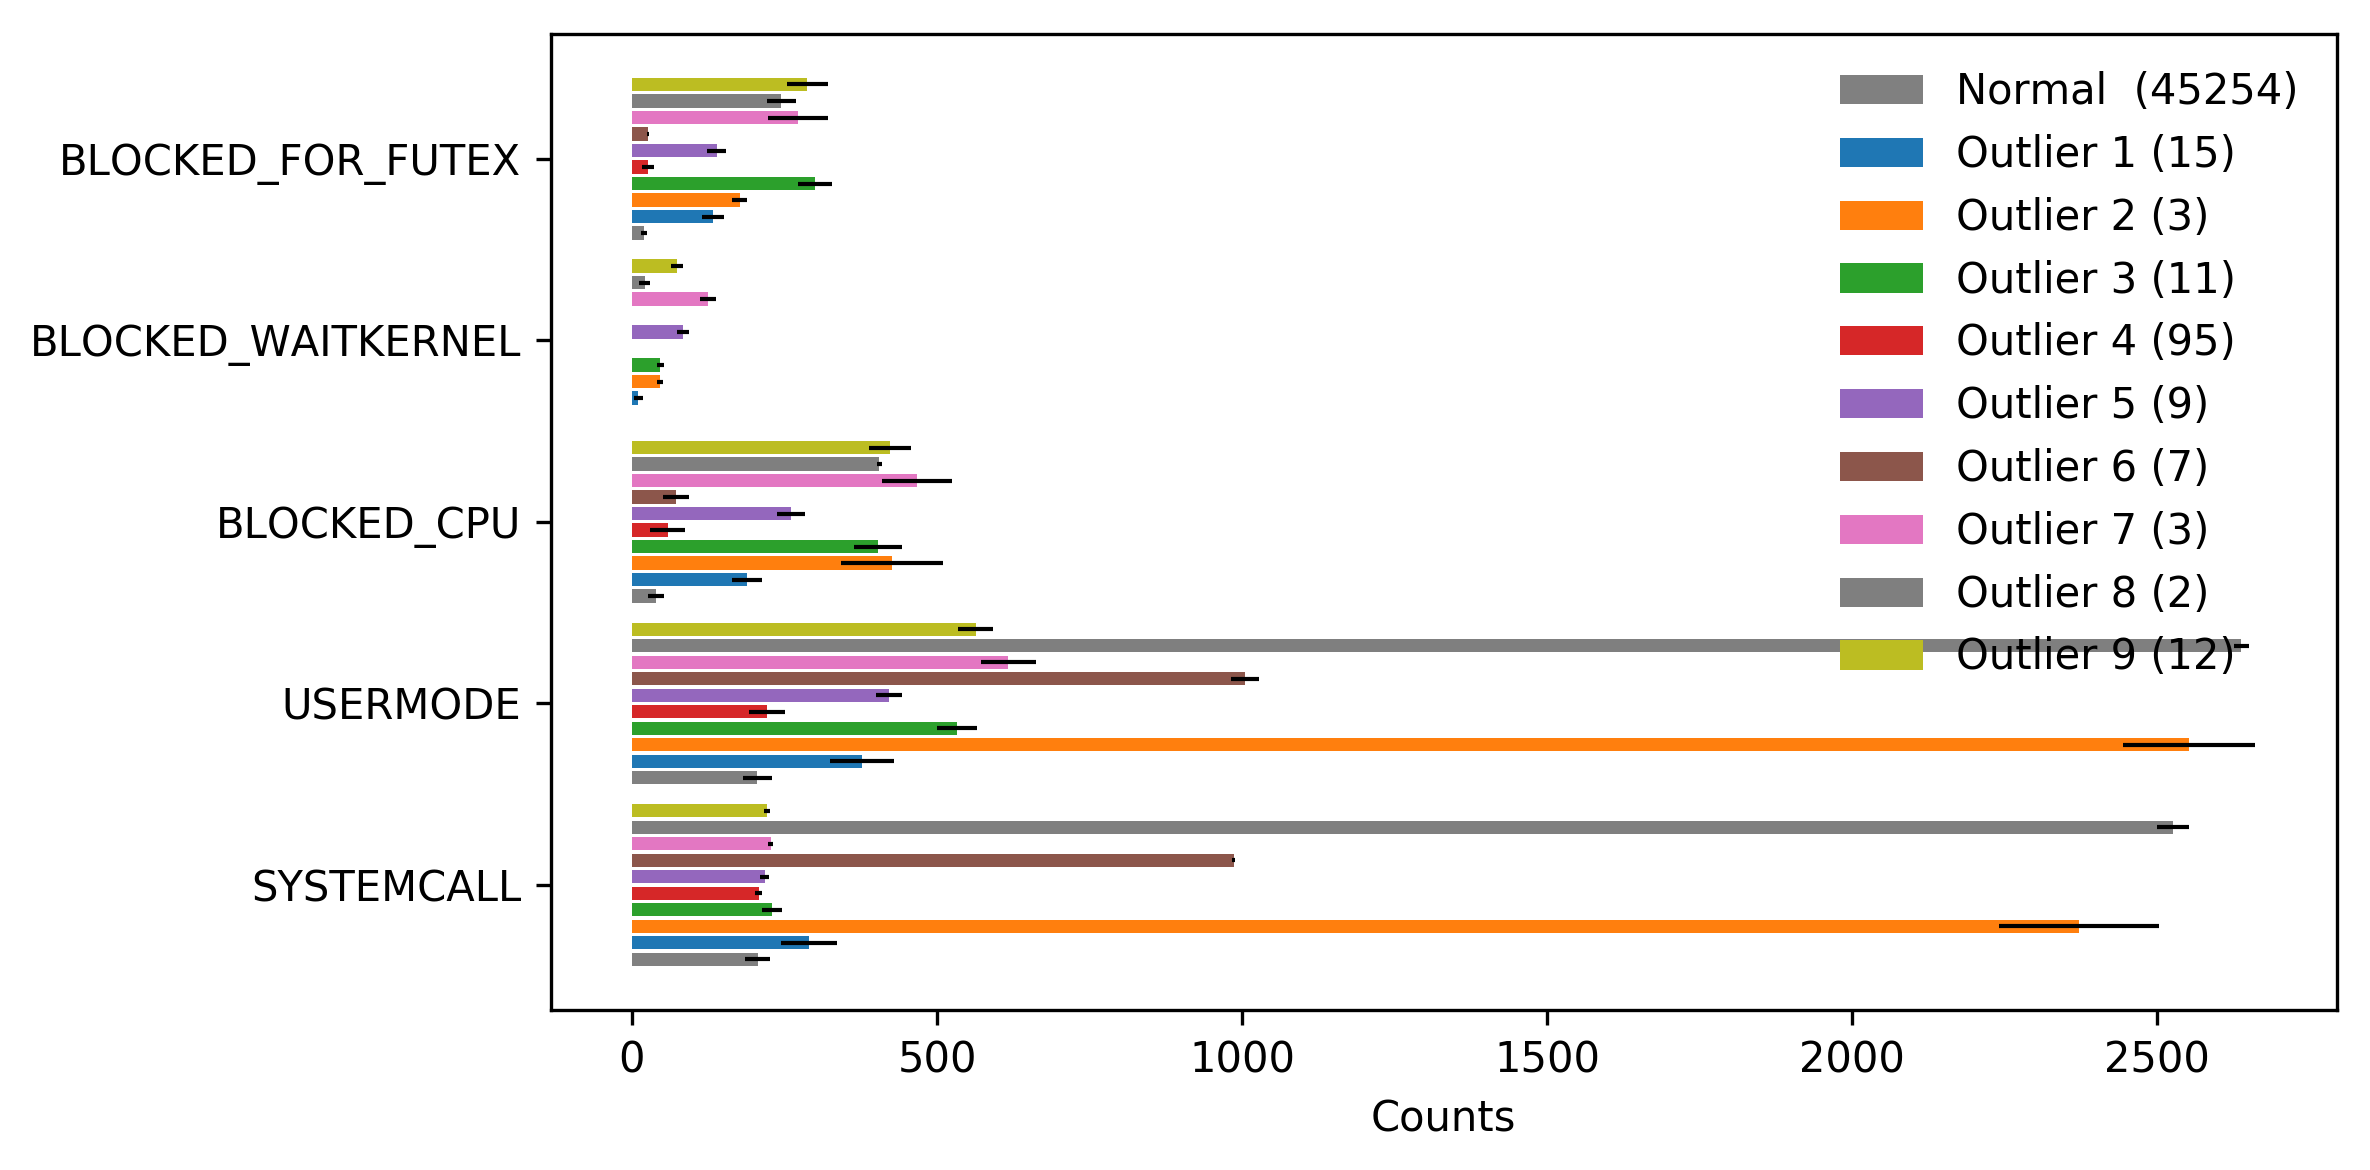

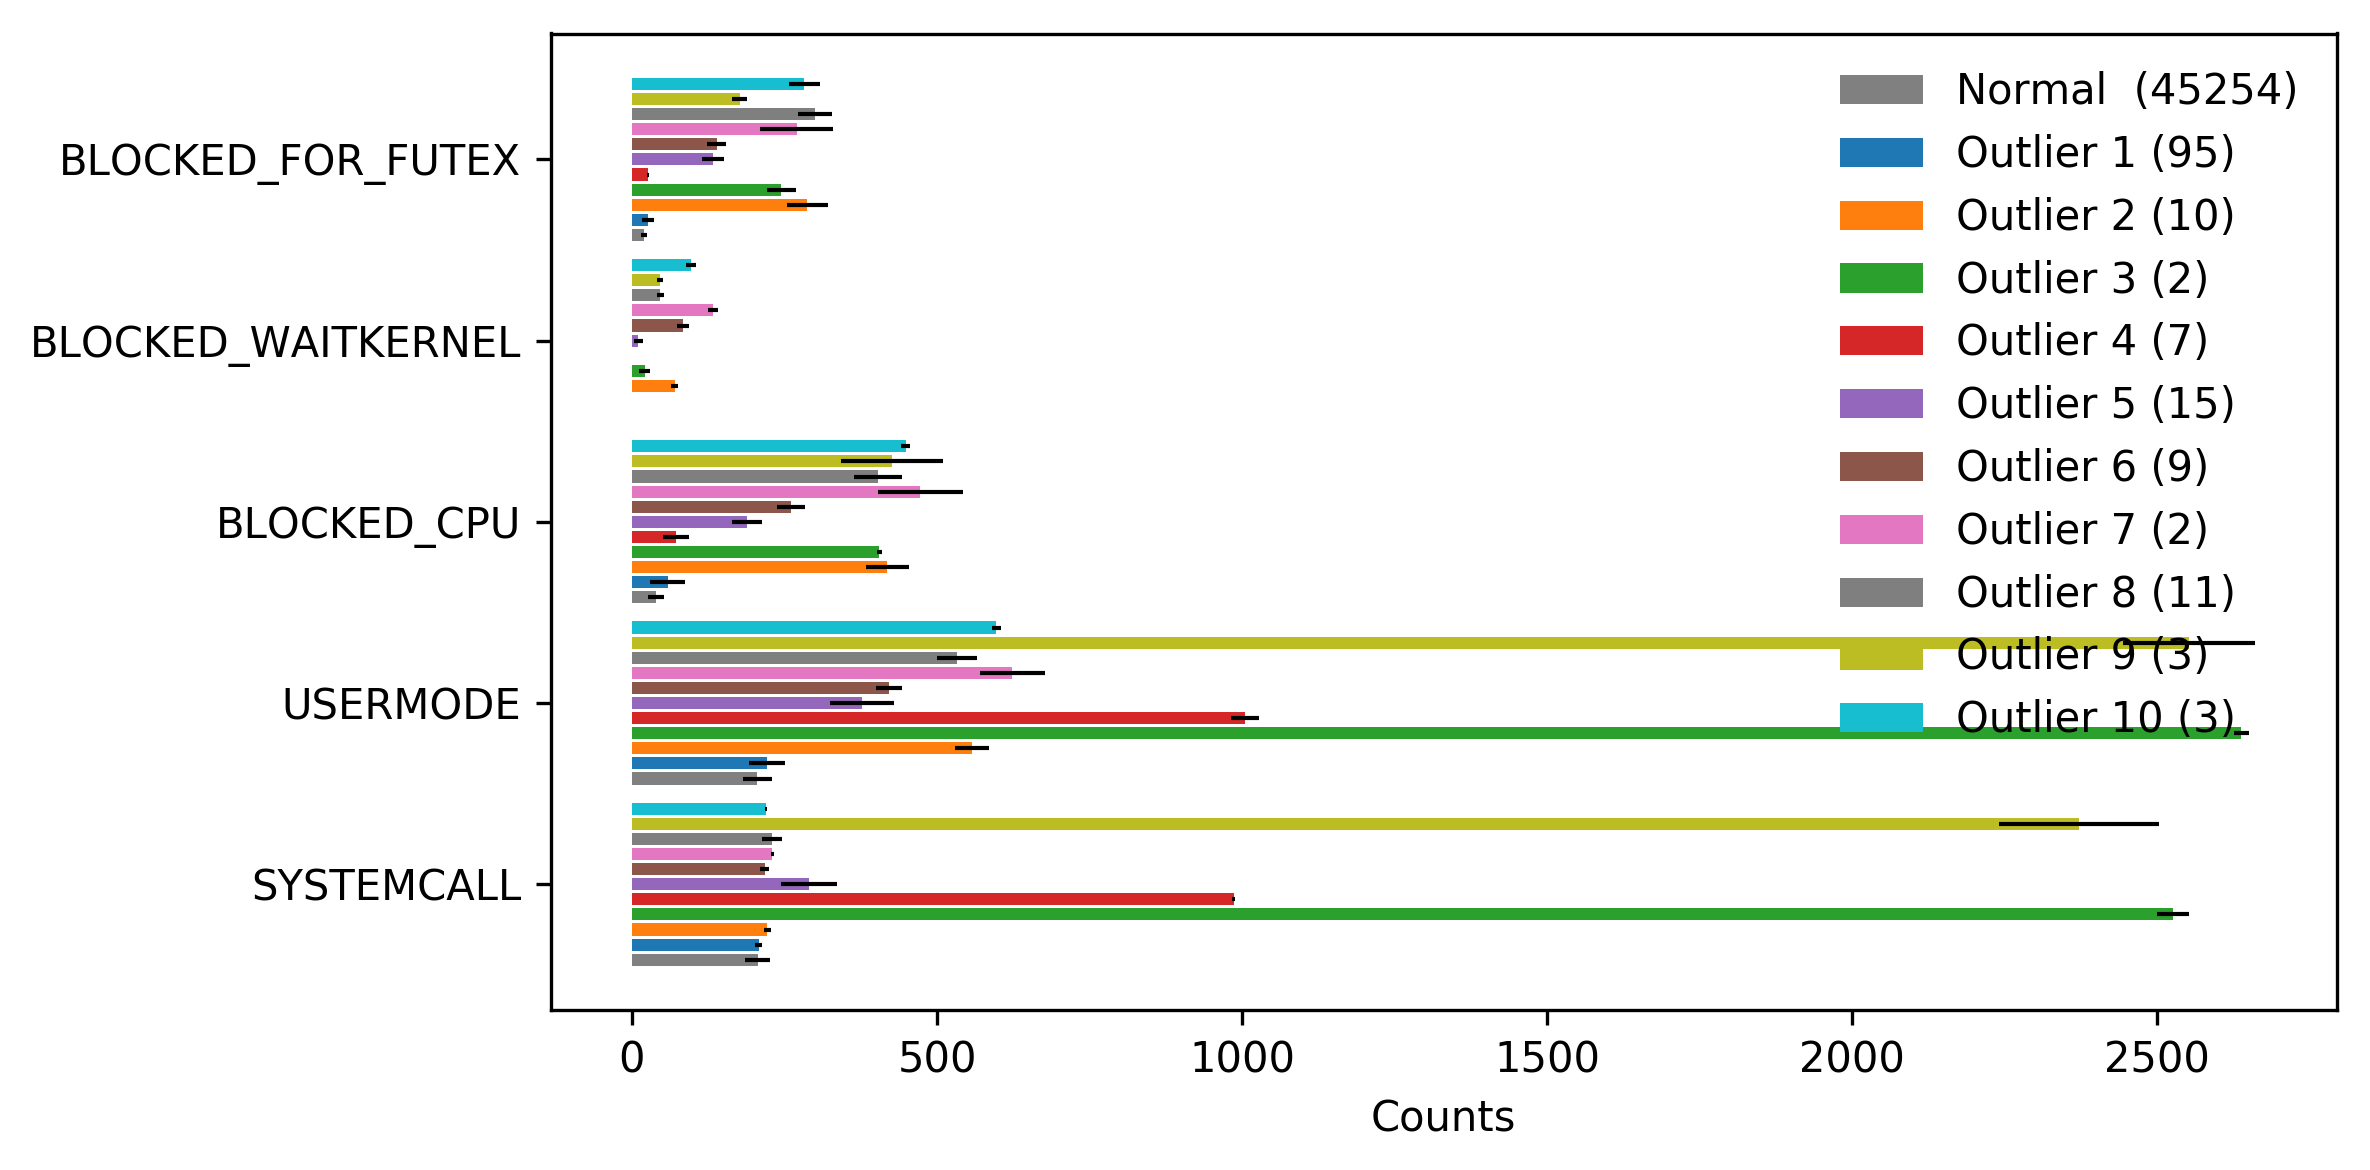

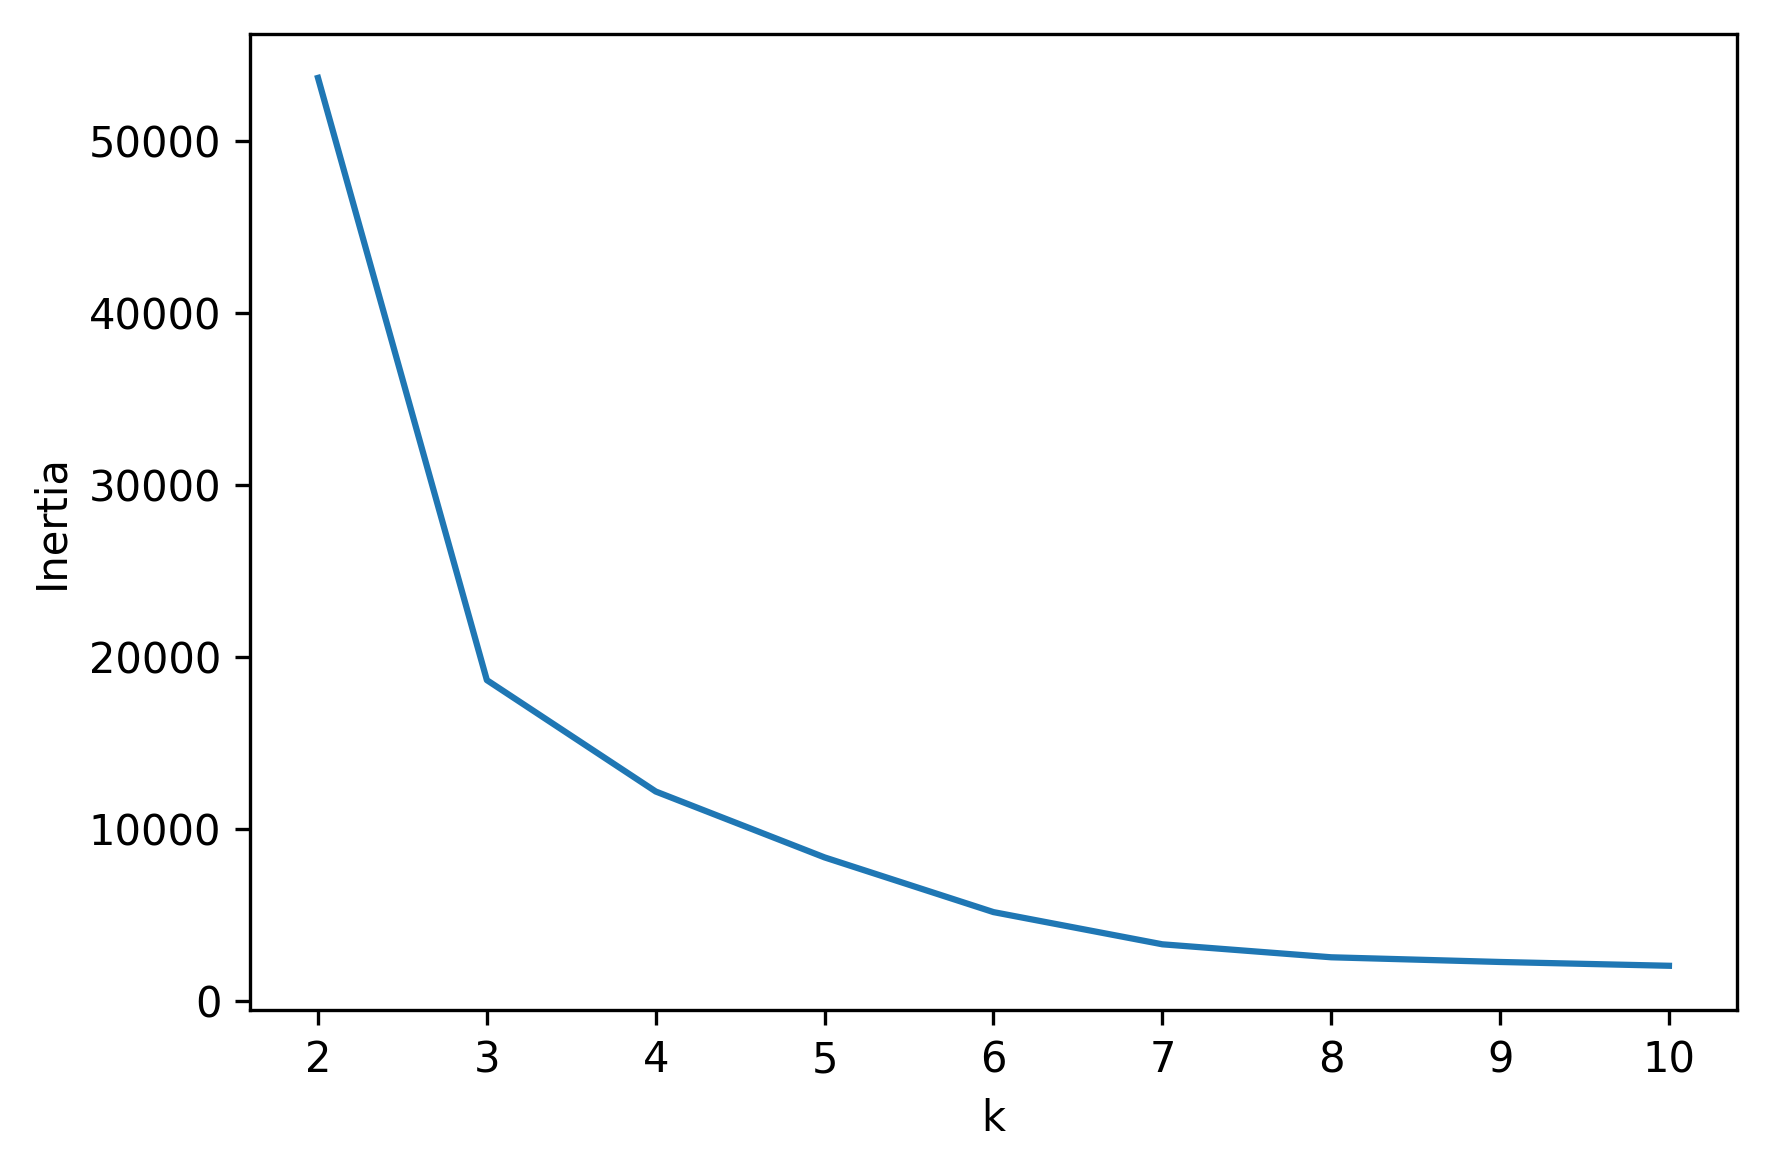

In [22]:
cluster_outliers(
    states,
    cluster, range(2, 11),
    name="kmeans_outliers",
    normalize=True,
    log=False)


In [23]:
k = 3

vocab, states_bow = seq2bow(states)

scaler = StandardScaler()
states_bow_norm = scaler.fit_transform(states_bow)
states_bow_norm_outlier = [v for c, v in zip(cluster, states_bow_norm) if c == -1]

kmeans = KMeans(n_clusters=k, max_iter=999, n_init=20, random_state=42, n_jobs=-1)
cluster_out = kmeans.fit_predict(states_bow_norm_outlier)


In [24]:
duration_out = [v for c, v in zip(cluster, duration) if c == -1]
duration_in = [v for c, v in zip(cluster, duration) if c != -1]

syscalls_out = [v for c, v in zip(cluster, syscalls) if c == -1]
syscalls_in = [v for c, v in zip(cluster, syscalls) if c != -1]

duration_per_cluster = [duration_in] + split_clusters(cluster_out, duration_out)
syscalls_per_cluster = [syscalls_in] + split_clusters(cluster_out, syscalls_out)


In [25]:
statistics_clustering(duration_per_cluster, syscalls_per_cluster)


--------------------------------------------------
Cluster 0
--------------------------------------------------
	Size                :      45254

Duration:
	Min                 :      20.50 ms
	Max                 :     323.83 ms
	Median              :     122.22 ms
	Mean                :     126.00 ms
	Std                 :      41.45 ms

Probabilities
	P(duration > 200ms) :     4.992%
	P(duration > 250ms) :     0.632%
	P(duration > 300ms) :     0.031%

System Call Sequence Length:
	Min                 :     191.00
	Max                 :    1058.00
	Median              :     247.00
	Mean                :     246.66
	Std                 :      24.44

Number of Distinct System Calls:
	Min                 :      26.00
	Max                 :      30.00
	Median              :      26.00
	Mean                :      26.01
	Std                 :       0.12

--------------------------------------------------
Cluster 1
--------------------------------------------------
	Size                :  

In [26]:
ngram_statistics(syscalls, cluster, cluster_out, ngram_range=(1,3), csv_file="ngram.csv")


# Performance evaluation

In [27]:
from functions import perf


In [28]:
model = DBSCAN(eps=25, min_samples=100, n_jobs=-1, algorithm='ball_tree')
perf(syscalls, states, times, duration, model)


Preprocessing: 1.102 ± 0.099s 
Outlier detection: 5.638 ± 0.922s 
Clustering of outliers: 0.034 ± 0.004s 
Ngram analysis: 17.202 ± 0.121s 


# Tracing Cost

In [29]:
import numpy as np
import matplotlib.pyplot as plt

In [30]:
clients, disabled, minimal, full = [], [], [], []
with open("tracing_cost.csv", "r") as file:
    # skip header
    next(file)
    for row in file:
        values = list(map(int, row.split(",")))
        clients.append(values[0])
        disabled.append(values[1])
        minimal.append(values[2])
        full.append(values[3])

In [31]:
disabled = np.asarray(disabled)
minimal =  np.asarray(minimal)
full =  np.asarray(full)

minimal_cost = (minimal-disabled)/disabled
full_cost = (full-disabled)/disabled

print("Minimal cost: {:.1%} ± {:.1%}%".format(np.mean(minimal_cost), np.std(minimal_cost)))
print("Full cost: {:.1%} ± {:.1%}%".format(np.mean(full_cost), np.std(full_cost)))

Minimal cost: -5.1% ± 1.9%%
Full cost: -29.6% ± 2.0%%


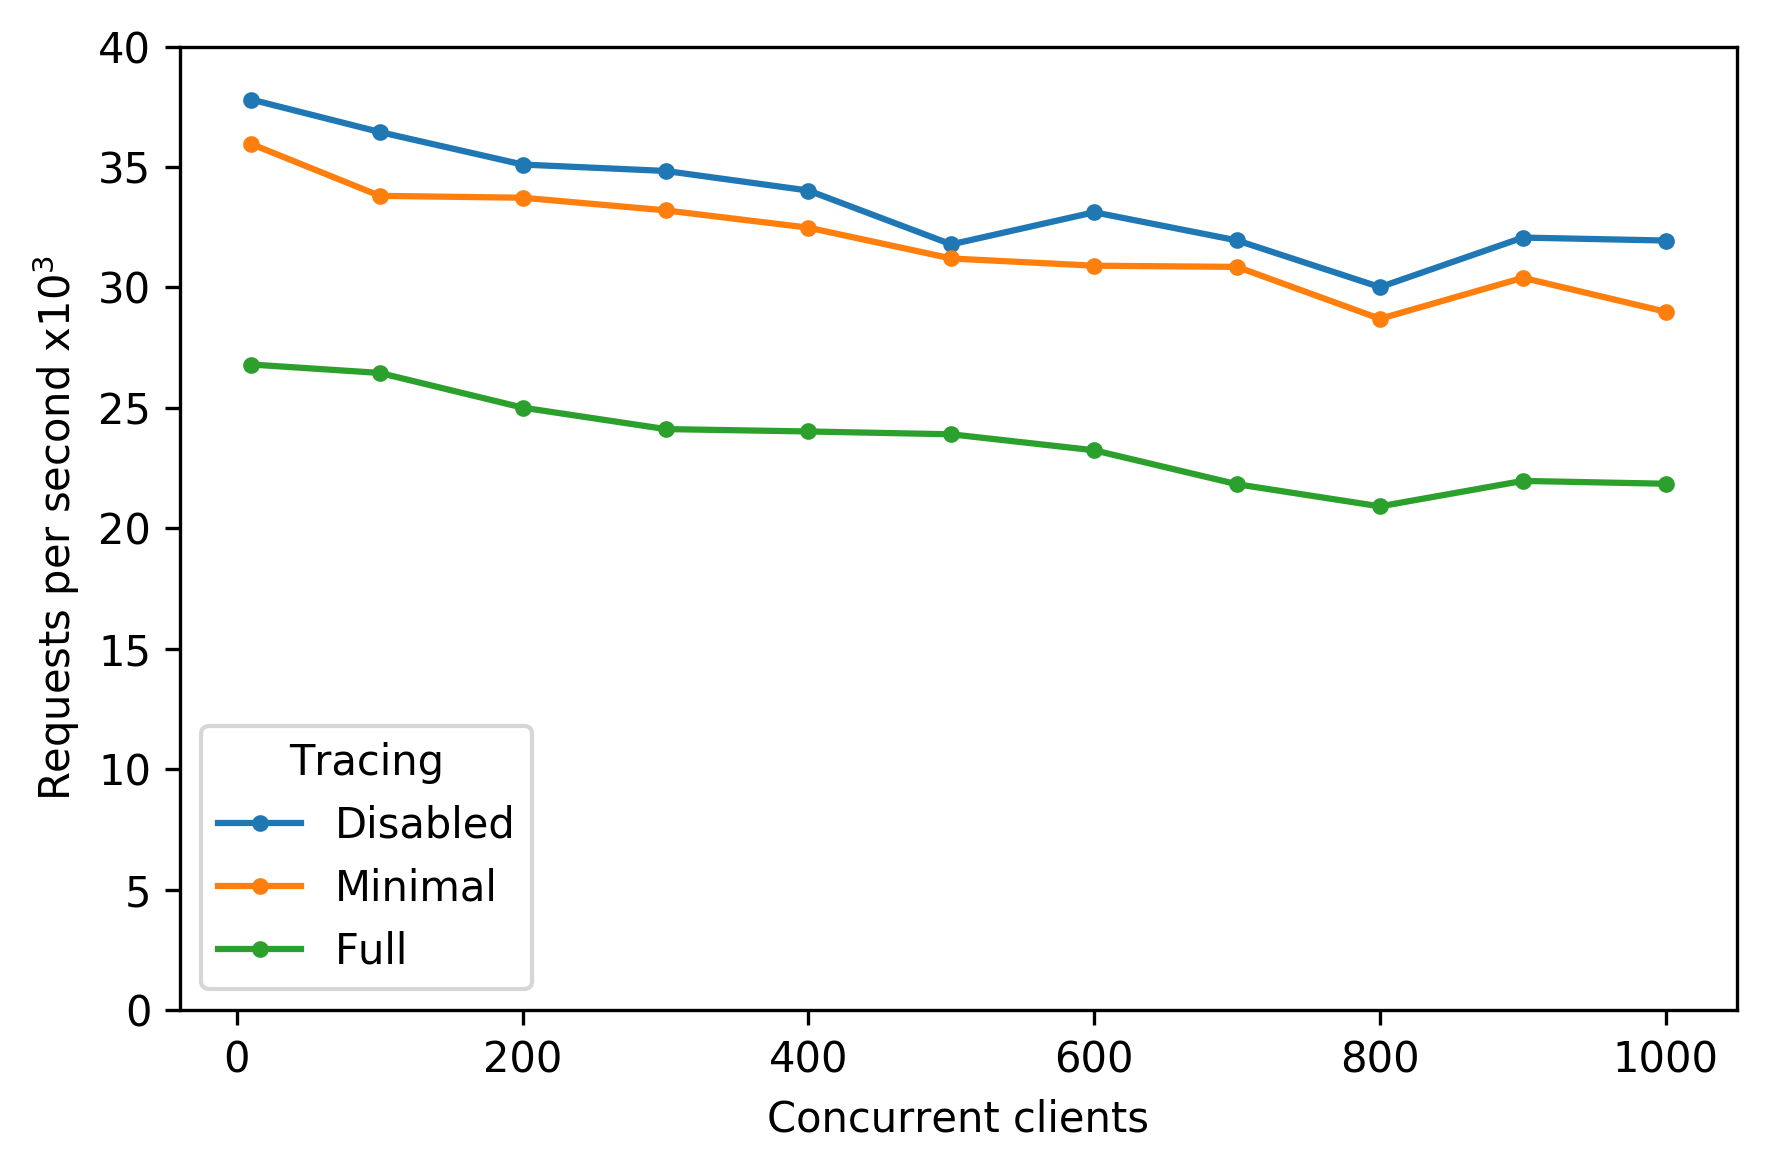

In [33]:
plt.figure(figsize=(6, 4), dpi=300)
plt.plot(clients, disabled / 1000, marker=".", label="Disabled")
plt.plot(clients, minimal / 1000, marker=".", label="Minimal")
plt.plot(clients, full / 1000, marker=".", label="Full")
plt.xlabel("Concurrent clients")
plt.ylabel(r'Requests per second x$10^3$')
plt.legend(title="Tracing")
plt.ylim((0, 40))
plt.tight_layout()
plt.savefig("figures/tracing_cost.png")
plt.show()
plt.close()